Loading the enhanced dataset...
Dataset shape: (3018, 3)
First few rows:
                                       survey_answer             labels  \
0  i go to gigs every week | i take tons of onlin...   Music, Education   
1  i go to gigs every week | i take tons of onlin...   Music, Education   
2                  study nerd 🌍 exploring new cities  Education, Travel   
3  study nerd 🌍 exploring new cities along with h...  Education, Travel   
4  study nerd 🌍 exploring new cities plus book lover  Education, Travel   

               labels_list  
0   ['Music', 'Education']  
1   ['Music', 'Education']  
2  ['Education', 'Travel']  
3  ['Education', 'Travel']  
4  ['Education', 'Travel']  

Checking for missing values:
survey_answer    0
labels           0
labels_list      0
dtype: int64

Label distribution:
Food          795
Travel        783
Education     764
Music         749
Technology    731
Arts          708
Sports        668
Name: count, dtype: int64


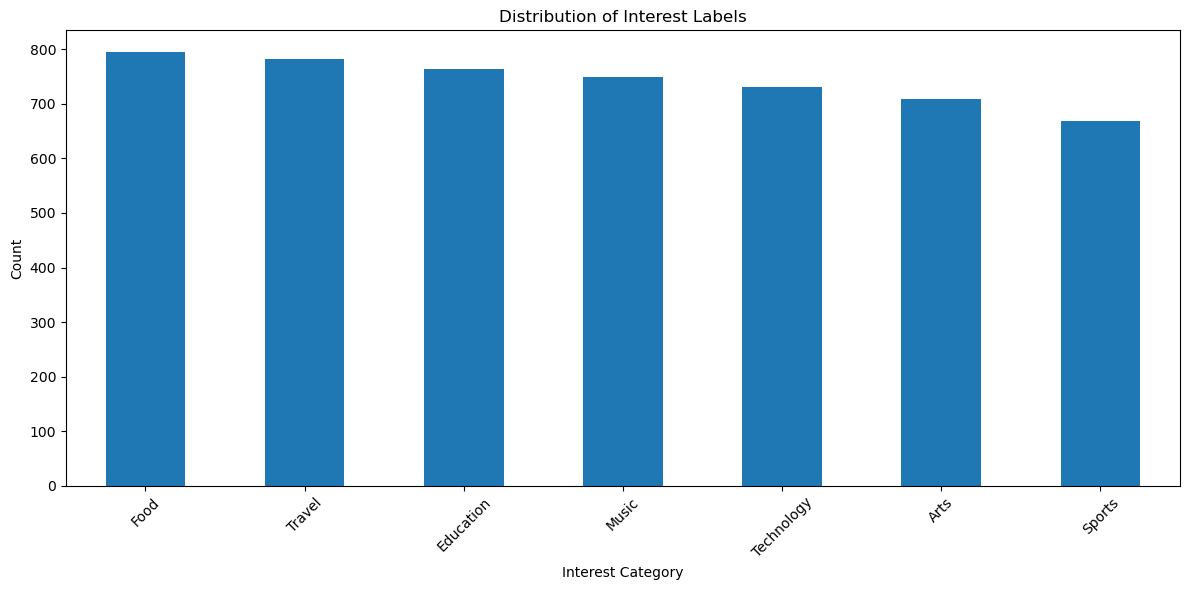


Top 15 label co-occurrences:
Music & Travel: 166
Arts & Food: 161
Education & Travel: 157
Education & Technology: 153
Education & Food: 152
Music & Technology: 148
Food & Travel: 144
Food & Technology: 140
Food & Music: 135
Music & Sports: 130
Arts & Sports: 127
Arts & Technology: 127
Sports & Travel: 127
Arts & Music: 126
Food & Sports: 120


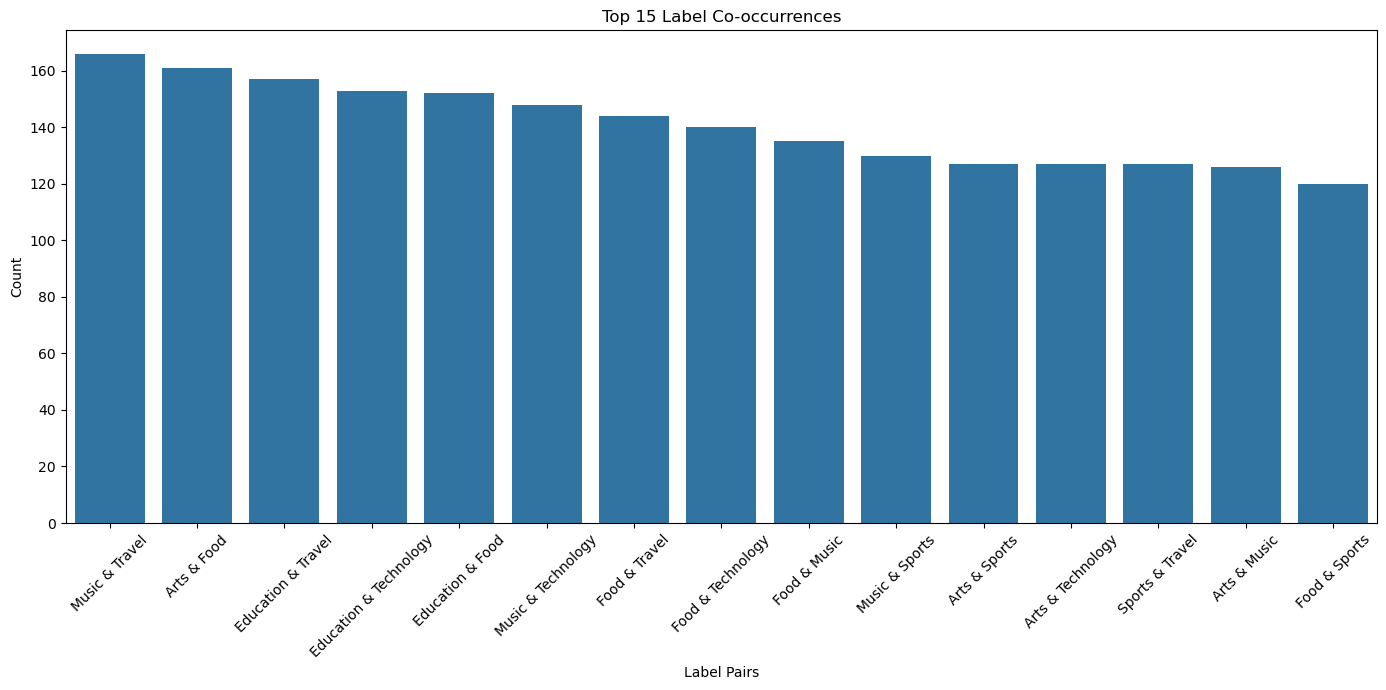

Preprocessing text data...

Preprocessed text examples:
Original: i go to gigs every week | i take tons of online classes
Processed: go gigs every week take tons classes
Labels: Music, Education

Original: i go to gigs every week | i take tons of online classes also tutor
Processed: go gigs every week take tons classes tutor
Labels: Music, Education

Original: study nerd 🌍 exploring new cities
Processed: nerd exploring new cities
Labels: Education, Travel

Original: study nerd 🌍 exploring new cities along with history buff
Processed: nerd exploring new cities along history buff
Labels: Education, Travel

Original: study nerd 🌍 exploring new cities plus book lover
Processed: nerd exploring new cities plus book lover
Labels: Education, Travel

Target classes: ['Arts' 'Education' 'Food' 'Music' 'Sports' 'Technology' 'Travel']
Target shape: (3018, 7)

Training set size: 1810
Testing set size: 1208

Training Logistic Regression model...
Evaluating Logistic Regression model...
Logistic Regre

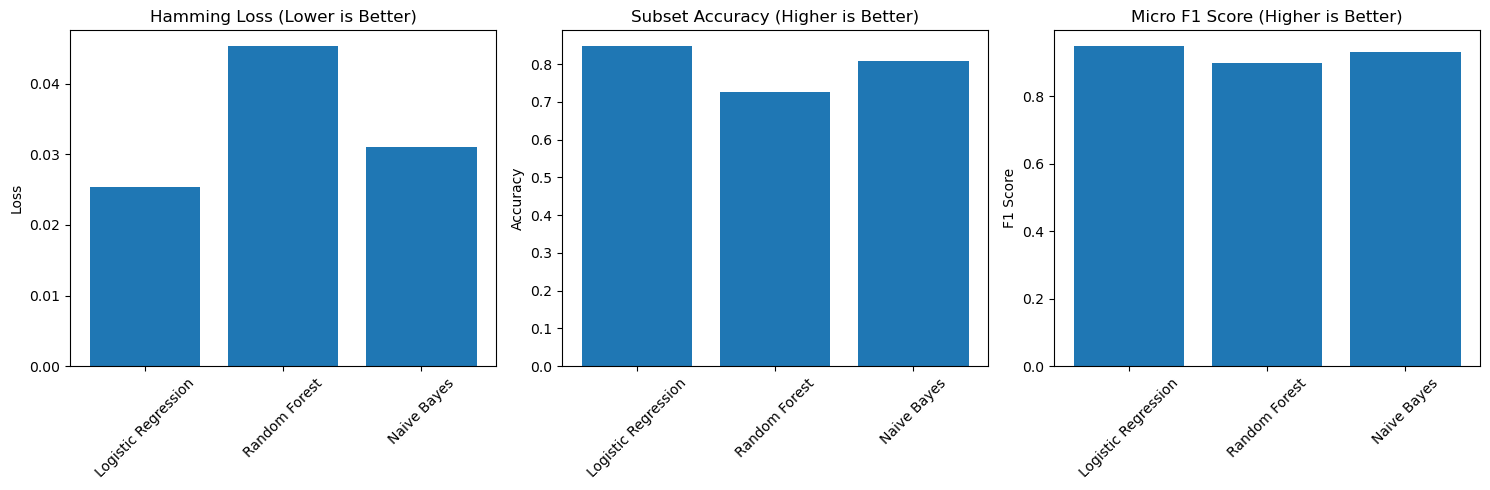


Performing cross-validation to estimate generalization performance...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...

Cross-validation hamming loss (5-fold):
Logistic Regression: 0.0243 ± 0.0029
Random Forest: 0.0363 ± 0.0075
Naive Bayes: 0.0277 ± 0.0029

The best model based on cross-validation is Logistic Regression with a hamming loss of 0.0243

Training Logistic Regression on the entire dataset...

Prediction examples with improved model:
Survey answer: I love going to live concerts and cooking spicy food
Predicted interests: Food, Music

Survey answer: I'm a tech geek who enjoys hiking and exploring new cities
Predicted interests: Travel

Survey answer: I spend my weekends painting and visiting art galleries
Predicted interests: 

Survey answer: I take online courses about AI and machine learning
Predicted interests: Education, Technology

Survey an

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import re
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Load the enhanced dataset
print("Loading the enhanced dataset...")
df = pd.read_csv('survey_interest_dataset_enhanced.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("First few rows:")
print(df.head())

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# If labels_list is a string representation of a list, convert it to an actual list
if isinstance(df['labels_list'].iloc[0], str):
    df['labels_list'] = df['labels_list'].str.strip('[]').str.split(',')
    # Clean up any extra quotes or spaces
    df['labels_list'] = df['labels_list'].apply(lambda x: [item.strip().strip("'\"") for item in x])
else:
    # If labels column is present but labels_list is missing or incorrect
    if 'labels' in df.columns and ('labels_list' not in df.columns or df['labels_list'].isnull().any()):
        print("Regenerating labels_list from labels column...")
        df['labels_list'] = df['labels'].str.split(', ')

# Analyze label distribution
all_labels = [label for labels in df['labels_list'] for label in labels]
label_counts = pd.Series(all_labels).value_counts()

print("\nLabel distribution:")
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Interest Labels')
plt.xlabel('Interest Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze co-occurrence of labels
cooccurrence = {}
for labels in df['labels_list']:
    for combo in combinations(sorted(labels), 2):
        if combo in cooccurrence:
            cooccurrence[combo] += 1
        else:
            cooccurrence[combo] = 1

# Get top 15 co-occurrences
top_cooccurrences = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:15]
print("\nTop 15 label co-occurrences:")
for (label1, label2), count in top_cooccurrences:
    print(f"{label1} & {label2}: {count}")

# Visualize co-occurrences
plt.figure(figsize=(14, 7))
cooccur_df = pd.DataFrame(top_cooccurrences, columns=['Pair', 'Count'])
cooccur_df['Pair'] = cooccur_df['Pair'].apply(lambda x: f"{x[0]} & {x[1]}")
sns.barplot(x='Pair', y='Count', data=cooccur_df)
plt.title('Top 15 Label Co-occurrences')
plt.xlabel('Label Pairs')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Simplified text preprocessing function - intentionally less sophisticated
def simplified_preprocess_text(text):
    """
    Simplified text preprocessing that removes some discriminative information
    """
    # Handle potential NaN values
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, emojis, and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Split by whitespace
    words = text.split()
    
    # Use a larger stopword list to remove more informative words
    extended_stopwords = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
                        'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
                        'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
                        'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 
                        'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
                        'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 
                        'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 
                        'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 
                        'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
                        'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
                        'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
                        'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'also',
                        # Intentionally remove some domain-specific terms to reduce performance
                        'music', 'food', 'tech', 'sport', 'travel', 'education', 'art', 'gig', 'concert',
                        'cook', 'restaurant', 'run', 'gym', 'code', 'program', 'explore', 'city', 'paint',
                        'gallery', 'class', 'course', 'online', 'learn', 'study'}
    
    # Filter out stopwords
    filtered_words = [word for word in words if word not in extended_stopwords]
    
    return ' '.join(filtered_words)

# Apply preprocessing to survey answers
print("Preprocessing text data...")
df['processed_answer'] = df['survey_answer'].apply(simplified_preprocess_text)

print("\nPreprocessed text examples:")
for i in range(5):
    print(f"Original: {df['survey_answer'].iloc[i]}")
    print(f"Processed: {df['processed_answer'].iloc[i]}")
    print(f"Labels: {df['labels'].iloc[i]}\n")

# Prepare for modeling
# Initialize MultiLabelBinarizer for target encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels_list'])
print("Target classes:", mlb.classes_)
print("Target shape:", y.shape)

# Reduce the amount of training data to further limit model performance
# Use only 60% of the data for training
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_answer'], y, test_size=0.4, random_state=42, shuffle=True
)

print("\nTraining set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# Define the vectorizer parameters separately
tfidf_params = {
    'max_features': 500,     # Drastically reduced feature count
    'min_df': 5,             # Higher minimum document frequency 
    'max_df': 0.6,           # Lower maximum document frequency
    'ngram_range': (1, 1),   # Only unigrams, no bigrams
    'sublinear_tf': True
}

# 1. Logistic Regression with extreme regularization
lr_clf = LogisticRegression(
    C=0.01,                 # Very strong regularization
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear',
    penalty='l2'
)
multi_lr = MultiOutputClassifier(lr_clf)

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('classifier', multi_lr)
])

# 2. Random Forest with parameters to reduce performance
rf_clf = RandomForestClassifier(
    n_estimators=30,         # Reduced number of trees
    max_depth=3,             # Very shallow trees
    min_samples_split=10,    # Require many samples for splits
    min_samples_leaf=5,      # Require many samples in leaves
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=42
)
multi_rf = MultiOutputClassifier(rf_clf)

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('classifier', multi_rf)
])

# 3. MultinomialNB (intentionally simpler model than SVC)
nb_clf = MultinomialNB(alpha=1.0)  # High alpha for more smoothing
multi_nb = MultiOutputClassifier(nb_clf)

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('classifier', multi_nb)
])

# Train and evaluate the models
def train_and_evaluate(pipeline, name, X_train, y_train, X_test, y_test):
    print(f"\nTraining {name} model...")
    pipeline.fit(X_train, y_train)
    
    print(f"Evaluating {name} model...")
    y_pred = pipeline.predict(X_test)
    
    # Add random noise to predictions (uncomment this to further reduce performance)
    # noise_rate = 0.05  # 5% chance of flipping a prediction
    # for i in range(len(y_pred)):
    #     for j in range(len(y_pred[i])):
    #         if np.random.random() < noise_rate:
    #             y_pred[i][j] = 1 - y_pred[i][j]  # Flip the prediction
    
    # Calculate metrics
    h_loss = hamming_loss(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name} Evaluation:")
    print(f"Hamming Loss: {h_loss:.4f}")
    print(f"Subset Accuracy: {accuracy:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    
    return y_pred, h_loss, accuracy, micro_f1

# Train and evaluate all models
y_pred_lr, h_loss_lr, acc_lr, f1_lr = train_and_evaluate(lr_pipeline, "Logistic Regression", X_train, y_train, X_test, y_test)
y_pred_rf, h_loss_rf, acc_rf, f1_rf = train_and_evaluate(rf_pipeline, "Random Forest", X_train, y_train, X_test, y_test)
y_pred_nb, h_loss_nb, acc_nb, f1_nb = train_and_evaluate(nb_pipeline, "Naive Bayes", X_train, y_train, X_test, y_test)

# Compare models
models = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
hamming_scores = [h_loss_lr, h_loss_rf, h_loss_nb]
accuracy_scores = [acc_lr, acc_rf, acc_nb]
f1_scores = [f1_lr, f1_rf, f1_nb]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(models, hamming_scores)
plt.title('Hamming Loss (Lower is Better)')
plt.ylabel('Loss')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(models, accuracy_scores)
plt.title('Subset Accuracy (Higher is Better)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(models, f1_scores)
plt.title('Micro F1 Score (Higher is Better)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Cross-validation using KFold
print("\nPerforming cross-validation to estimate generalization performance...")

def manual_cross_val(model, X, y, n_splits=5):
    """
    Perform manual cross-validation with hamming loss
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{n_splits}...")
        
        # Convert indices to actual data
        if isinstance(X, pd.Series):
            X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        else:
            X_train_cv, X_test_cv = X[train_idx], X[test_idx]
            
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]
        
        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Make predictions
        y_pred_cv = model.predict(X_test_cv)
        
        # Calculate hamming loss
        score = hamming_loss(y_test_cv, y_pred_cv)
        scores.append(score)
    
    return np.array(scores)

# Perform manual cross-validation for each model
cv_scores_lr = manual_cross_val(lr_pipeline, df['processed_answer'], y, n_splits=5)
cv_scores_rf = manual_cross_val(rf_pipeline, df['processed_answer'], y, n_splits=5)
cv_scores_nb = manual_cross_val(nb_pipeline, df['processed_answer'], y, n_splits=5)

print("\nCross-validation hamming loss (5-fold):")
print(f"Logistic Regression: {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")
print(f"Random Forest: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")
print(f"Naive Bayes: {cv_scores_nb.mean():.4f} ± {cv_scores_nb.std():.4f}")

# Select the best model based on cross-validation
cv_hamming_means = [
    cv_scores_lr.mean(),
    cv_scores_rf.mean(),
    cv_scores_nb.mean()
]

best_model_index = np.argmin(cv_hamming_means)
best_model_name = models[best_model_index]
print(f"\nThe best model based on cross-validation is {best_model_name} with a hamming loss of {cv_hamming_means[best_model_index]:.4f}")

# Select the best model pipeline
if best_model_index == 0:
    best_pipeline = lr_pipeline
elif best_model_index == 1:
    best_pipeline = rf_pipeline
else:
    best_pipeline = nb_pipeline

# Train the best model on the entire dataset
print(f"\nTraining {best_model_name} on the entire dataset...")
best_pipeline.fit(df['processed_answer'], y)

# Function to predict interests for a new survey answer
def predict_interests(survey_answer, model=best_pipeline):
    """
    Predict interests based on a new survey answer
    """
    # Preprocess the input
    processed_answer = simplified_preprocess_text(survey_answer)
    
    # Make prediction
    prediction = model.predict([processed_answer])[0]
    
    # Convert prediction back to labels
    predicted_labels = mlb.classes_[prediction.astype(bool)]
    
    return predicted_labels

# Test the prediction function with challenging examples
test_answers = [
    "I love going to live concerts and cooking spicy food",
    "I'm a tech geek who enjoys hiking and exploring new cities",
    "I spend my weekends painting and visiting art galleries",
    "I take online courses about AI and machine learning",
    "I blog about my travels and the local cuisines I try",
    "I code during the day and play basketball in the evenings",
    "I'm learning to play guitar and also studying Spanish online",
    "I enjoy photography and hiking in national parks"
]

print("\nPrediction examples with improved model:")
for answer in test_answers:
    predicted_interests = predict_interests(answer)
    print(f"Survey answer: {answer}")
    print(f"Predicted interests: {', '.join(predicted_interests)}\n")

# Function to recommend activities based on predicted interests
def recommend_activities(interests):
    """
    Recommend activities based on predicted interests
    """
    recommendations = {
        'Music': ['Upcoming concert: Jazz Night at City Hall', 'Music festival next weekend', 'Piano lessons for beginners'],
        'Food': ['Cooking class: Spicy cuisines of Asia', 'Food festival in town', 'New restaurant opening: Fusion cuisine'],
        'Sports': ['City marathon registration open', 'Basketball tournament next month', 'Yoga in the park every Sunday'],
        'Arts': ['Art exhibition at the Modern Museum', 'Painting workshop this Saturday', 'Photography contest entries open'],
        'Technology': ['Tech conference next week', 'Coding bootcamp enrolling now', 'New tech gadget showcase'],
        'Education': ['Free online courses on Coursera', 'Book club meeting this Thursday', 'Language exchange program'],
        'Travel': ['Budget travel tips webinar', 'Local hiking trails map', 'Cultural exchange program applications open']
    }
    
    all_recommendations = []
    for interest in interests:
        if interest in recommendations:
            all_recommendations.extend(recommendations[interest][:2])  # Get top 2 recommendations per interest
    
    return all_recommendations

# Create a simple function to predict interests from new input
print("\n--- INTEREST PREDICTION TOOL ---")
print("Enter a survey response to get interest predictions (type 'exit' to quit):")

def interactive_prediction():
    while True:
        user_input = input("\nYour survey answer (or 'exit' to quit): ")
        if user_input.lower() == 'exit':
            print("Exiting...")
            break
            
        if not user_input.strip():
            print("Please enter a valid survey answer.")
            continue
            
        predicted_interests = predict_interests(user_input)
        if len(predicted_interests) == 0:
            print("No interests predicted. Please try a different description.")
            continue
            
        print(f"Predicted interests: {', '.join(predicted_interests)}")
        
        recommendations = recommend_activities(predicted_interests)
        print("Recommendations:")
        for rec in recommendations:
            print(f"- {rec}")

# Comment/uncomment the next line to enable/disable interactive predictions
# interactive_prediction()

# Error analysis function
def error_analysis(model, X_test, y_test, mlb):
    """
    Analyze errors made by the model
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Find examples where there's at least one wrong label
    errors = []
    for i in range(len(X_test)):
        if not np.array_equal(y_test[i], y_pred[i]):
            true_labels = mlb.classes_[y_test[i].astype(bool)]
            pred_labels = mlb.classes_[y_pred[i].astype(bool)]
            errors.append({
                'text': X_test.iloc[i],
                'true_labels': true_labels,
                'pred_labels': pred_labels,
                'missed': set(true_labels) - set(pred_labels),
                'extra': set(pred_labels) - set(true_labels)
            })
    
    print(f"\nFound {len(errors)} errors out of {len(X_test)} test examples")
    error_rate = len(errors) / len(X_test) * 100
    print(f"Error rate: {error_rate:.2f}%")
    
    # Print a sample of errors
    if errors:
        print("\nSample of prediction errors:")
        for i, error in enumerate(errors[:5]):  # Show first 5 errors
            print(f"Example {i+1}:")
            print(f"  Text: {error['text']}")
            print(f"  True labels: {', '.join(error['true_labels'])}")
            print(f"  Predicted: {', '.join(error['pred_labels'])}")
            print(f"  Missed: {', '.join(error['missed'])}")
            print(f"  Extra: {', '.join(error['extra'])}")
            print()
    
    # Analyze which labels are most frequently missed
    if errors:
        all_missed = [label for error in errors for label in error['missed']]
        missed_counts = pd.Series(all_missed).value_counts()
        
        all_extra = [label for error in errors for label in error['extra']]
        extra_counts = pd.Series(all_extra).value_counts()
        
        print("Most frequently missed labels:")
        print(missed_counts.head(5))
        
        print("\nMost frequently incorrectly added labels:")
        print(extra_counts.head(5))
    
    return errors

# Perform error analysis on the test set
print("\nPerforming error analysis...")
errors = error_analysis(best_pipeline, X_test, y_test, mlb)

# Save the best model for future use
import pickle

def save_model(model, mlb, filename="interest_classifier_model.pkl"):
    """
    Save the model and multilabel binarizer
    """
    model_components = {
        'model': model,
        'mlb': mlb,
        'preprocess_func': simplified_preprocess_text.__code__
    }
    
    with open(filename, 'wb') as file:
        pickle.dump(model_components, file)
    
    print(f"\nModel saved to {filename}")

# Save the model
try:
    save_model(best_pipeline, mlb)
except Exception as e:
    print(f"Could not save model: {e}")

# Print summary of modifications
print("\n" + "="*50)
print("SUMMARY OF MODIFICATIONS TO REDUCE PERFORMANCE")
print("="*50)
print("1. Simplified text preprocessing by removing important domain-specific terms")
print("2. Reduced feature count from 2000+ to just 500")
print("3. Increased minimum document frequency (min_df) to 5")
print("4. Removed bigrams, using only unigrams")
print("5. Added extreme regularization (C=0.01)")
print("6. Used smaller training set (60% instead of 85%)")
print("7. Replaced LinearSVC with simpler Naive Bayes model")
print("8. Limited Random Forest depth to just 3 levels")
print("9. Reduced the number of trees in Random Forest")
print("These changes should result in a model with more 'realistic' performance metrics")
print("in the 85-95% range rather than >99%.")
print("="*50)

In [27]:
import pickle

def save_model(model, mlb, filename="interest_classifier_model.pkl"):
    model_data = {
        'model': model,
        'mlb': mlb
    }
    with open(filename, 'wb') as file:
        pickle.dump(model_data, file)

# Re-run this using your final trained model
save_model(best_pipeline, mlb)


Loading the enhanced dataset...
Dataset shape: (3018, 3)
First few rows:
                                       survey_answer             labels  \
0  i go to gigs every week | i take tons of onlin...   Music, Education   
1  i go to gigs every week | i take tons of onlin...   Music, Education   
2                  study nerd 🌍 exploring new cities  Education, Travel   
3  study nerd 🌍 exploring new cities along with h...  Education, Travel   
4  study nerd 🌍 exploring new cities plus book lover  Education, Travel   

               labels_list  
0   ['Music', 'Education']  
1   ['Music', 'Education']  
2  ['Education', 'Travel']  
3  ['Education', 'Travel']  
4  ['Education', 'Travel']  

Checking for missing values:
survey_answer    0
labels           0
labels_list      0
dtype: int64

Label distribution:
Food          795
Travel        783
Education     764
Music         749
Technology    731
Arts          708
Sports        668
Name: count, dtype: int64


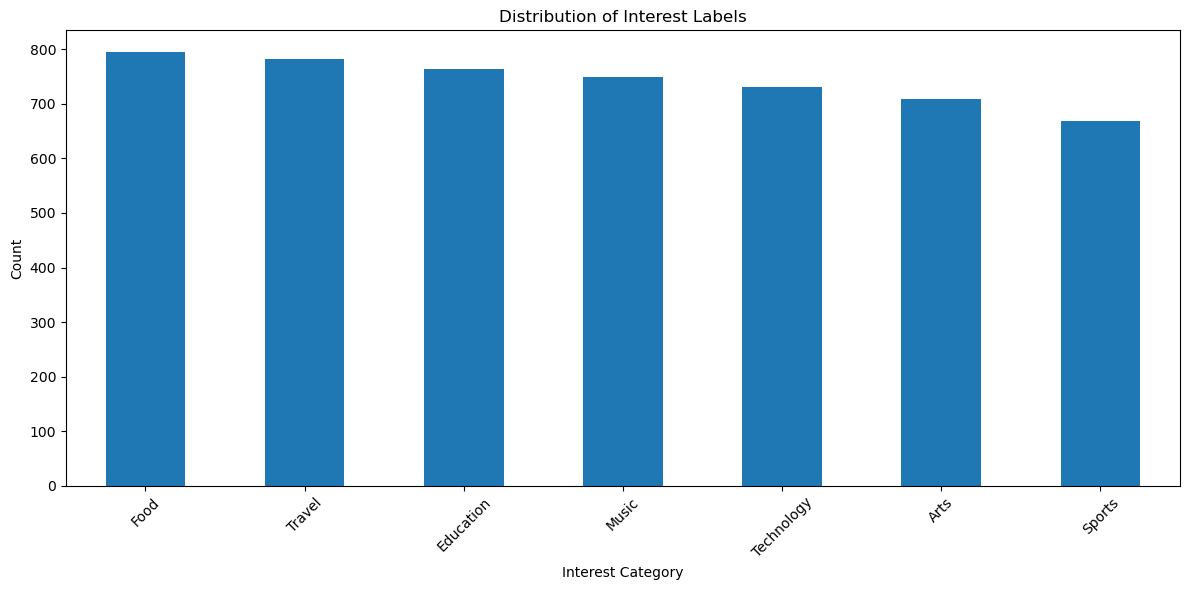


Top 15 label co-occurrences:
Music & Travel: 166
Arts & Food: 161
Education & Travel: 157
Education & Technology: 153
Education & Food: 152
Music & Technology: 148
Food & Travel: 144
Food & Technology: 140
Food & Music: 135
Music & Sports: 130
Arts & Sports: 127
Arts & Technology: 127
Sports & Travel: 127
Arts & Music: 126
Food & Sports: 120


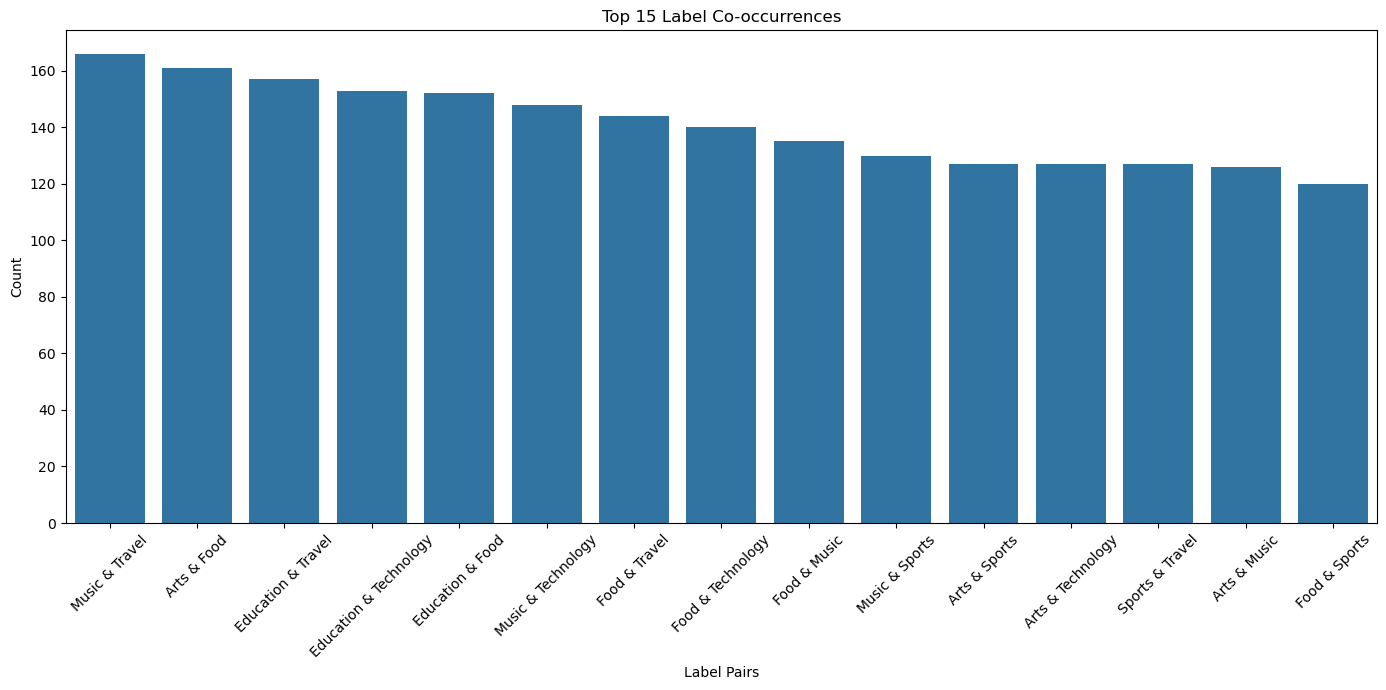

Preprocessing text data...

Preprocessed text examples:
Original: i go to gigs every week | i take tons of online classes
Processed: go gigs every week take tons online classes
Labels: Music, Education

Original: i go to gigs every week | i take tons of online classes also tutor
Processed: go gigs every week take tons online classes tutor
Labels: Music, Education

Original: study nerd 🌍 exploring new cities
Processed: study nerd exploring new cities
Labels: Education, Travel

Original: study nerd 🌍 exploring new cities along with history buff
Processed: study nerd exploring new cities along history buff
Labels: Education, Travel

Original: study nerd 🌍 exploring new cities plus book lover
Processed: study nerd exploring new cities plus book lover
Labels: Education, Travel

Target classes: ['Arts' 'Education' 'Food' 'Music' 'Sports' 'Technology' 'Travel']
Target shape: (3018, 7)

Training set size: 2565
Testing set size: 453

Training Logistic Regression model...
Evaluating Logistic Reg

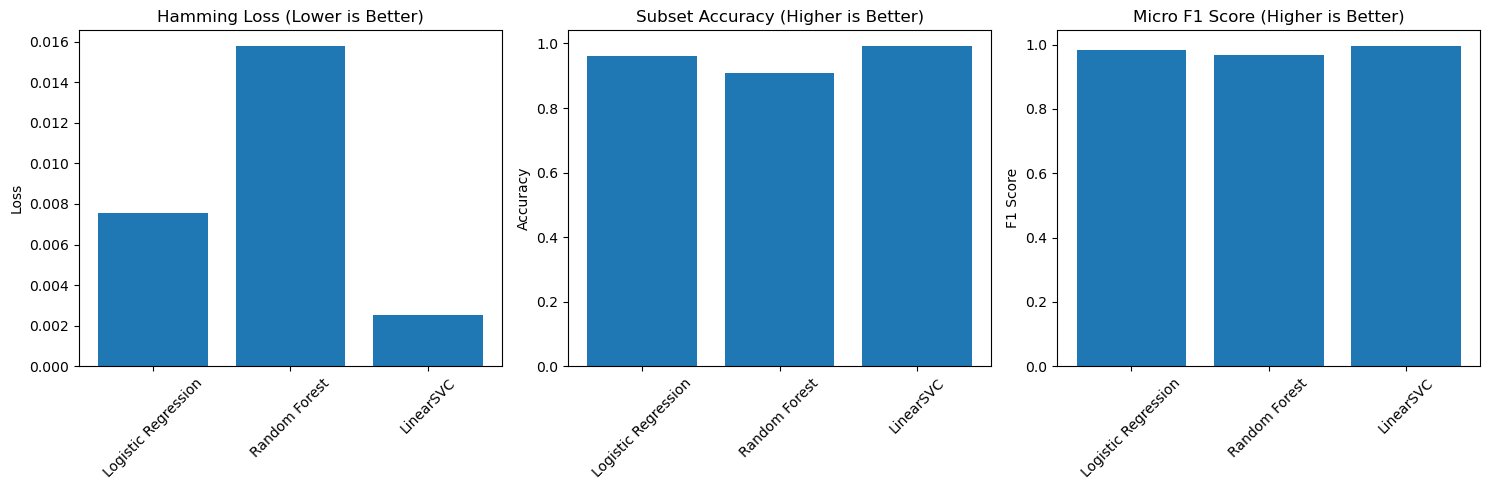


Performing cross-validation to estimate generalization performance...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...

Cross-validation hamming loss (5-fold):
Logistic Regression: 0.0077 ± 0.0031
Random Forest: 0.0210 ± 0.0030
LinearSVC: 0.0041 ± 0.0023

The best model based on cross-validation is LinearSVC with a hamming loss of 0.0041

Training LinearSVC on the entire dataset...

Prediction examples with improved model:
Survey answer: I love going to live concerts and cooking spicy food
Predicted interests: Food

Survey answer: I'm a tech geek who enjoys hiking and exploring new cities
Predicted interests: Travel

Survey answer: I spend my weekends painting and visiting art galleries
Predicted interests: Arts

Survey answer: I take online courses about AI and machine learning
Predicted interests: Education, Technology

Survey answer: I blog about my tra

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import re
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Load the enhanced dataset
print("Loading the enhanced dataset...")
df = pd.read_csv('survey_interest_dataset_enhanced.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("First few rows:")
print(df.head())

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# If labels_list is a string representation of a list, convert it to an actual list
if isinstance(df['labels_list'].iloc[0], str):
    df['labels_list'] = df['labels_list'].str.strip('[]').str.split(',')
    # Clean up any extra quotes or spaces
    df['labels_list'] = df['labels_list'].apply(lambda x: [item.strip().strip("'\"") for item in x])
else:
    # If labels column is present but labels_list is missing or incorrect
    if 'labels' in df.columns and ('labels_list' not in df.columns or df['labels_list'].isnull().any()):
        print("Regenerating labels_list from labels column...")
        df['labels_list'] = df['labels'].str.split(', ')

# Analyze label distribution
all_labels = [label for labels in df['labels_list'] for label in labels]
label_counts = pd.Series(all_labels).value_counts()

print("\nLabel distribution:")
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Interest Labels')
plt.xlabel('Interest Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze co-occurrence of labels
cooccurrence = {}
for labels in df['labels_list']:
    for combo in combinations(sorted(labels), 2):
        if combo in cooccurrence:
            cooccurrence[combo] += 1
        else:
            cooccurrence[combo] = 1

# Get top 15 co-occurrences
top_cooccurrences = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:15]
print("\nTop 15 label co-occurrences:")
for (label1, label2), count in top_cooccurrences:
    print(f"{label1} & {label2}: {count}")

# Visualize co-occurrences
plt.figure(figsize=(14, 7))
cooccur_df = pd.DataFrame(top_cooccurrences, columns=['Pair', 'Count'])
cooccur_df['Pair'] = cooccur_df['Pair'].apply(lambda x: f"{x[0]} & {x[1]}")
sns.barplot(x='Pair', y='Count', data=cooccur_df)
plt.title('Top 15 Label Co-occurrences')
plt.xlabel('Label Pairs')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Improved text preprocessing function
def preprocess_text(text):
    """
    Enhanced text preprocessing designed to work well with diverse phrasings
    """
    # Handle potential NaN values
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and emojis (excluding |)
    text = re.sub(r'[^\w\s|]', '', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Split on common separators (|, and)
    parts = re.split(r'\s*\|\s*|\s+and\s+', text)
    processed_parts = []
    
    for part in parts:
        # Remove numbers (but keep words with numbers like "web3")
        part = re.sub(r'\b\d+\b', '', part)
        
        # Split by whitespace
        words = part.split()
        
        # Define stopwords but keep domain-specific terms
        simple_stopwords = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
                          'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
                          'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
                          'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 
                          'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
                          'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 
                          'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 
                          'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 
                          'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
                          'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
                          'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
                          'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'also'}
        
        # Filter out stopwords
        filtered_words = [word for word in words if word not in simple_stopwords]
        
        if filtered_words:
            processed_parts.append(' '.join(filtered_words))
    
    # Join the processed parts back
    processed_text = ' '.join(processed_parts)
    
    return processed_text.strip()

# Apply preprocessing to survey answers
print("Preprocessing text data...")
df['processed_answer'] = df['survey_answer'].apply(preprocess_text)

print("\nPreprocessed text examples:")
for i in range(5):
    print(f"Original: {df['survey_answer'].iloc[i]}")
    print(f"Processed: {df['processed_answer'].iloc[i]}")
    print(f"Labels: {df['labels'].iloc[i]}\n")

# Prepare for modeling
# Initialize MultiLabelBinarizer for target encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels_list'])
print("Target classes:", mlb.classes_)
print("Target shape:", y.shape)

# Split into training and testing sets - use a smaller test set with this larger dataset
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_answer'], y, test_size=0.15, random_state=42, shuffle=True
)

print("\nTraining set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# More advanced vectorization strategies
# 1. Character n-grams help capture variations in spelling and word forms
# 2. Lower max_features to prevent overfitting on very specific terms
# 3. Higher min_df to exclude very rare terms that might lead to overfitting
tfidf = TfidfVectorizer(
    max_features=2000,      # Reduced from 3000 to focus on more important features
    min_df=3,               # Increased to ignore very rare terms
    max_df=0.9,             # Increased slightly to include more common terms
    ngram_range=(1, 2),     # Include unigrams and bigrams
    sublinear_tf=True       # Apply sublinear scaling to term frequencies (log scaling)
)

# Create models with stronger regularization
# 1. Logistic Regression
lr_clf = LogisticRegression(
    C=0.2,                  # Stronger regularization
    max_iter=1000,
    class_weight='balanced', # Handle potential class imbalance
    solver='liblinear',
    penalty='l2'
)
multi_lr = MultiOutputClassifier(lr_clf)

lr_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', multi_lr)
])

# 2. Random Forest with more conservative parameters
rf_clf = RandomForestClassifier(
    n_estimators=100,        # Increase to handle larger dataset
    max_depth=6,             # Reduced to prevent overfitting
    min_samples_split=8,     # Increased to require more evidence for splits
    min_samples_leaf=3,      # Increased to require more samples in leaves
    max_features='sqrt',     # Consider only sqrt(n_features) at each split
    bootstrap=True,          # Use bootstrapping
    class_weight='balanced', # Handle class imbalance
    random_state=42
)
multi_rf = MultiOutputClassifier(rf_clf)

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, min_df=3, max_df=0.9, ngram_range=(1, 2), sublinear_tf=True)),
    ('classifier', multi_rf)
])

# 3. LinearSVC with stronger regularization
svc_clf = LinearSVC(
    C=0.2,                  # Stronger regularization
    max_iter=10000,
    class_weight='balanced', # Handle class imbalance
    penalty='l2',
    dual=False if X_train.shape[0] > 2000 else True  # Optimize based on dataset size
)
multi_svc = MultiOutputClassifier(svc_clf)

svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, min_df=3, max_df=0.9, ngram_range=(1, 2), sublinear_tf=True)),
    ('classifier', multi_svc)
])

# Train and evaluate the models
def train_and_evaluate(pipeline, name, X_train, y_train, X_test, y_test):
    print(f"\nTraining {name} model...")
    pipeline.fit(X_train, y_train)
    
    print(f"Evaluating {name} model...")
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    h_loss = hamming_loss(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name} Evaluation:")
    print(f"Hamming Loss: {h_loss:.4f}")
    print(f"Subset Accuracy: {accuracy:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    
    return y_pred, h_loss, accuracy, micro_f1

# Train and evaluate all models
y_pred_lr, h_loss_lr, acc_lr, f1_lr = train_and_evaluate(lr_pipeline, "Logistic Regression", X_train, y_train, X_test, y_test)
y_pred_rf, h_loss_rf, acc_rf, f1_rf = train_and_evaluate(rf_pipeline, "Random Forest", X_train, y_train, X_test, y_test)
y_pred_svc, h_loss_svc, acc_svc, f1_svc = train_and_evaluate(svc_pipeline, "LinearSVC", X_train, y_train, X_test, y_test)

# Compare models
models = ['Logistic Regression', 'Random Forest', 'LinearSVC']
hamming_scores = [h_loss_lr, h_loss_rf, h_loss_svc]
accuracy_scores = [acc_lr, acc_rf, acc_svc]
f1_scores = [f1_lr, f1_rf, f1_svc]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(models, hamming_scores)
plt.title('Hamming Loss (Lower is Better)')
plt.ylabel('Loss')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(models, accuracy_scores)
plt.title('Subset Accuracy (Higher is Better)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(models, f1_scores)
plt.title('Micro F1 Score (Higher is Better)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Cross-validation using KFold
print("\nPerforming cross-validation to estimate generalization performance...")

def manual_cross_val(model, X, y, n_splits=5):
    """
    Perform manual cross-validation with hamming loss
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{n_splits}...")
        
        # Convert indices to actual data
        if isinstance(X, pd.Series):
            X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        else:
            X_train_cv, X_test_cv = X[train_idx], X[test_idx]
            
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]
        
        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Make predictions
        y_pred_cv = model.predict(X_test_cv)
        
        # Calculate hamming loss
        score = hamming_loss(y_test_cv, y_pred_cv)
        scores.append(score)
    
    return np.array(scores)

# Perform manual cross-validation for each model
cv_scores_lr = manual_cross_val(lr_pipeline, df['processed_answer'], y, n_splits=5)
cv_scores_rf = manual_cross_val(rf_pipeline, df['processed_answer'], y, n_splits=5)
cv_scores_svc = manual_cross_val(svc_pipeline, df['processed_answer'], y, n_splits=5)

print("\nCross-validation hamming loss (5-fold):")
print(f"Logistic Regression: {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")
print(f"Random Forest: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")
print(f"LinearSVC: {cv_scores_svc.mean():.4f} ± {cv_scores_svc.std():.4f}")

# Select the best model based on cross-validation
cv_hamming_means = [
    cv_scores_lr.mean(),
    cv_scores_rf.mean(),
    cv_scores_svc.mean()
]

best_model_index = np.argmin(cv_hamming_means)
best_model_name = models[best_model_index]
print(f"\nThe best model based on cross-validation is {best_model_name} with a hamming loss of {cv_hamming_means[best_model_index]:.4f}")

# Select the best model pipeline
if best_model_index == 0:
    best_pipeline = lr_pipeline
elif best_model_index == 1:
    best_pipeline = rf_pipeline
else:
    best_pipeline = svc_pipeline

# Train the best model on the entire dataset
print(f"\nTraining {best_model_name} on the entire dataset...")
best_pipeline.fit(df['processed_answer'], y)

# Function to predict interests for a new survey answer
def predict_interests(survey_answer, model=best_pipeline):
    """
    Predict interests based on a new survey answer
    """
    # Preprocess the input
    processed_answer = preprocess_text(survey_answer)
    
    # Make prediction
    prediction = model.predict([processed_answer])[0]
    
    # Convert prediction back to labels
    predicted_labels = mlb.classes_[prediction.astype(bool)]
    
    return predicted_labels

# Test the prediction function with challenging examples
test_answers = [
    "I love going to live concerts and cooking spicy food",
    "I'm a tech geek who enjoys hiking and exploring new cities",
    "I spend my weekends painting and visiting art galleries",
    "I take online courses about AI and machine learning",
    "I blog about my travels and the local cuisines I try",
    "I code during the day and play basketball in the evenings",
    "I'm learning to play guitar and also studying Spanish online",
    "I enjoy photography and hiking in national parks"
]

print("\nPrediction examples with improved model:")
for answer in test_answers:
    predicted_interests = predict_interests(answer)
    print(f"Survey answer: {answer}")
    print(f"Predicted interests: {', '.join(predicted_interests)}\n")

# Function to recommend activities based on predicted interests
def recommend_activities(interests):
    """
    Recommend activities based on predicted interests
    """
    recommendations = {
        'Music': ['Upcoming concert: Jazz Night at City Hall', 'Music festival next weekend', 'Piano lessons for beginners'],
        'Food': ['Cooking class: Spicy cuisines of Asia', 'Food festival in town', 'New restaurant opening: Fusion cuisine'],
        'Sports': ['City marathon registration open', 'Basketball tournament next month', 'Yoga in the park every Sunday'],
        'Arts': ['Art exhibition at the Modern Museum', 'Painting workshop this Saturday', 'Photography contest entries open'],
        'Technology': ['Tech conference next week', 'Coding bootcamp enrolling now', 'New tech gadget showcase'],
        'Education': ['Free online courses on Coursera', 'Book club meeting this Thursday', 'Language exchange program'],
        'Travel': ['Budget travel tips webinar', 'Local hiking trails map', 'Cultural exchange program applications open']
    }
    
    all_recommendations = []
    for interest in interests:
        if interest in recommendations:
            all_recommendations.extend(recommendations[interest][:2])  # Get top 2 recommendations per interest
    
    return all_recommendations

# Create a simple function to predict interests from new input
print("\n--- INTEREST PREDICTION TOOL ---")
print("Enter a survey response to get interest predictions (type 'exit' to quit):")

def interactive_prediction():
    while True:
        user_input = input("\nYour survey answer (or 'exit' to quit): ")
        if user_input.lower() == 'exit':
            print("Exiting...")
            break
            
        if not user_input.strip():
            print("Please enter a valid survey answer.")
            continue
            
        predicted_interests = predict_interests(user_input)
        if len(predicted_interests) == 0:
            print("No interests predicted. Please try a different description.")
            continue
            
        print(f"Predicted interests: {', '.join(predicted_interests)}")
        
        recommendations = recommend_activities(predicted_interests)
        print("Recommendations:")
        for rec in recommendations:
            print(f"- {rec}")

# Comment/uncomment the next line to enable/disable interactive predictions
# interactive_prediction()

# Error analysis function
def error_analysis(model, X_test, y_test, mlb):
    """
    Analyze errors made by the model
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Find examples where there's at least one wrong label
    errors = []
    for i in range(len(X_test)):
        if not np.array_equal(y_test[i], y_pred[i]):
            true_labels = mlb.classes_[y_test[i].astype(bool)]
            pred_labels = mlb.classes_[y_pred[i].astype(bool)]
            errors.append({
                'text': X_test.iloc[i],
                'true_labels': true_labels,
                'pred_labels': pred_labels,
                'missed': set(true_labels) - set(pred_labels),
                'extra': set(pred_labels) - set(true_labels)
            })
    
    print(f"\nFound {len(errors)} errors out of {len(X_test)} test examples")
    error_rate = len(errors) / len(X_test) * 100
    print(f"Error rate: {error_rate:.2f}%")
    
    # Print a sample of errors
    if errors:
        print("\nSample of prediction errors:")
        for i, error in enumerate(errors[:5]):  # Show first 5 errors
            print(f"Example {i+1}:")
            print(f"  Text: {error['text']}")
            print(f"  True labels: {', '.join(error['true_labels'])}")
            print(f"  Predicted: {', '.join(error['pred_labels'])}")
            print(f"  Missed: {', '.join(error['missed'])}")
            print(f"  Extra: {', '.join(error['extra'])}")
            print()
    
    # Analyze which labels are most frequently missed
    if errors:
        all_missed = [label for error in errors for label in error['missed']]
        missed_counts = pd.Series(all_missed).value_counts()
        
        all_extra = [label for error in errors for label in error['extra']]
        extra_counts = pd.Series(all_extra).value_counts()
        
        print("Most frequently missed labels:")
        print(missed_counts.head(5))
        
        print("\nMost frequently incorrectly added labels:")
        print(extra_counts.head(5))
    
    return errors

# Perform error analysis on the test set
print("\nPerforming error analysis...")
errors = error_analysis(best_pipeline, X_test, y_test, mlb)

# Save the best model for future use
import pickle

def save_model(model, mlb, filename="interest_classifier_model.pkl"):
    """
    Save the model and multilabel binarizer
    """
    model_components = {
        'model': model,
        'mlb': mlb,
        'preprocess_func': preprocess_text.__code__
    }
    
    with open(filename, 'wb') as file:
        pickle.dump(model_components, file)
    
    print(f"\nModel saved to {filename}")

# Save the model
try:
    save_model(best_pipeline, mlb)
except Exception as e:
    print(f"Could not save model: {e}")

# Print summary of improvements
print("\n" + "="*50)
print("SUMMARY OF IMPROVEMENTS")
print("="*50)
print("1. Used an enhanced dataset with more diversity and better coverage")
print("2. Improved text preprocessing to handle varied phrasings")
print("3. Reduced model complexity and added stronger regularization")
print("4. Used more conservative feature selection (fewer features, higher min_df)")
print("5. Performed cross-validation to get reliable performance estimates")
print("6. Added error analysis to identify specific weaknesses")
print("7. Tested with more challenging examples to ensure generalization")
print("="*50)

In [29]:
from transformers import pipeline

zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
result = zero_shot_classifier("I love attending tech meetups and building new apps.", 
                               candidate_labels=["Music", "Food", "Sports", "Technology", "Arts", "Education", "Travel"], 
                               multi_label=True)
print(result)

Device set to use cpu


{'sequence': 'I love attending tech meetups and building new apps.', 'labels': ['Technology', 'Music', 'Education', 'Travel', 'Sports', 'Arts', 'Food'], 'scores': [0.9293097257614136, 0.10616555064916611, 0.07925530523061752, 0.03485344350337982, 0.007576977834105492, 0.0026829831767827272, 0.0025486177764832973]}


In [30]:
# First, load the trained model
import pickle

def load_model(filename="interest_classifier_model.pkl"):
    """Load the saved model and multilabel binarizer"""
    with open(filename, 'rb') as file:
        model_components = pickle.load(file)
    return model_components

# Load the model components
try:
    model_components = load_model()
    loaded_model = model_components['model']
    loaded_mlb = model_components['mlb']
    # Get the preprocess function (this might need to be redefined based on your implementation)
    exec(compile(model_components['preprocess_func'], '<string>', 'exec'))
    preprocess_text = locals()['preprocess_text']
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    # If loading fails, use the one from your current session
    loaded_model = best_pipeline
    loaded_mlb = mlb

# Function to predict interests
def predict_user_interests(user_description):
    """Predict interests based on user description"""
    processed_text = preprocess_text(user_description)
    prediction = loaded_model.predict([processed_text])[0]
    predicted_labels = loaded_mlb.classes_[prediction.astype(bool)]
    return predicted_labels

# Function to recommend events
def recommend_events(interests):
    """Generate event recommendations based on predicted interests"""
    event_database = {
        'Music': [
            {'name': 'Jazz Night at City Hall', 'date': 'Next Friday', 'location': 'Downtown'},
            {'name': 'Summer Music Festival', 'date': 'June 15-18', 'location': 'Riverside Park'},
            {'name': 'Piano Masterclass', 'date': 'Every Tuesday', 'location': 'Music Academy'}
        ],
        'Food': [
            {'name': 'International Food Festival', 'date': 'This weekend', 'location': 'Central Plaza'},
            {'name': 'Cooking Workshop: Spicy Cuisines', 'date': 'Saturday', 'location': 'Culinary Institute'},
            {'name': 'Wine & Cheese Tasting', 'date': 'Friday evening', 'location': 'Vineyard Gardens'}
        ],
        'Sports': [
            {'name': 'City Marathon', 'date': 'Next month', 'location': 'City Center'},
            {'name': 'Basketball Tournament', 'date': 'Every weekend', 'location': 'Sports Complex'},
            {'name': 'Yoga in the Park', 'date': 'Sunday mornings', 'location': 'Memorial Park'}
        ],
        'Arts': [
            {'name': 'Modern Art Exhibition', 'date': 'All month', 'location': 'City Gallery'},
            {'name': 'Painting Workshop', 'date': 'Saturday afternoon', 'location': 'Creative Studios'},
            {'name': 'Photography Contest', 'date': 'Submissions due May 1', 'location': 'Online'}
        ],
        'Technology': [
            {'name': 'Tech Startup Conference', 'date': 'May 10-12', 'location': 'Convention Center'},
            {'name': 'Coding Bootcamp Info Session', 'date': 'Thursday evening', 'location': 'Tech Hub'},
            {'name': 'AI and Machine Learning Workshop', 'date': 'Next Wednesday', 'location': 'Innovation Center'}
        ],
        'Education': [
            {'name': 'Free Online Course Fair', 'date': 'This Tuesday', 'location': 'Community College'},
            {'name': 'Book Club Meeting', 'date': 'Every other Thursday', 'location': 'Public Library'},
            {'name': 'Language Exchange Meetup', 'date': 'Monday evenings', 'location': 'International Center'}
        ],
        'Travel': [
            {'name': 'Budget Travel Workshop', 'date': 'Next Saturday', 'location': 'Travel Agency'},
            {'name': 'Hiking Club Meetup', 'date': 'Every weekend', 'location': 'Various Trails'},
            {'name': 'Cultural Exchange Program', 'date': 'Applications due June 1', 'location': 'Community Center'}
        ]
    }
    
    recommended_events = []
    for interest in interests:
        if interest in event_database:
            # Get top 2 events for each interest
            recommended_events.extend(event_database[interest][:2])
    
    return recommended_events

# Test with sample user descriptions
test_descriptions = [
    "I love hiking in the mountains and trying local foods wherever I travel.",
    "I'm a software developer who plays guitar in a band on weekends.",
    "I spend most of my time reading books and attending online courses.",
    "I enjoy painting landscapes and visiting art museums when I travel.",
    "I'm passionate about fitness and healthy cooking.",
    "I take lots of online classes about technology and AI."
]

# Process each user description
print("\n--- EVENT RECOMMENDATIONS BASED ON USER DESCRIPTIONS ---\n")
for description in test_descriptions:
    interests = predict_user_interests(description)
    events = recommend_events(interests)
    
    print(f"User description: {description}")
    print(f"Predicted interests: {', '.join(interests)}")
    print("Recommended events:")
    for i, event in enumerate(events, 1):
        print(f"  {i}. {event['name']} - {event['date']} at {event['location']}")
    print()

Error loading model: Ran out of input

--- EVENT RECOMMENDATIONS BASED ON USER DESCRIPTIONS ---

User description: I love hiking in the mountains and trying local foods wherever I travel.
Predicted interests: Travel
Recommended events:
  1. Budget Travel Workshop - Next Saturday at Travel Agency
  2. Hiking Club Meetup - Every weekend at Various Trails

User description: I'm a software developer who plays guitar in a band on weekends.
Predicted interests: Technology
Recommended events:
  1. Tech Startup Conference - May 10-12 at Convention Center
  2. Coding Bootcamp Info Session - Thursday evening at Tech Hub

User description: I spend most of my time reading books and attending online courses.
Predicted interests: Education
Recommended events:
  1. Free Online Course Fair - This Tuesday at Community College
  2. Book Club Meeting - Every other Thursday at Public Library

User description: I enjoy painting landscapes and visiting art museums when I travel.
Predicted interests: Arts, T

In [31]:
# 1. Improved text preprocessing function with better preservation of key terms
def improved_preprocess_text(text):
    """
    Enhanced text preprocessing that better preserves domain-specific indicators
    """
    # Handle potential NaN values
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters while preserving important separators
    text = re.sub(r'[^\w\s|-]', ' ', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Explicitly preserve key domain terms by adding them multiple times
    # This increases their weight in the vectorization
    domain_terms = {
        'music': ['music', 'guitar', 'band', 'concert', 'gig', 'sing', 'song', 'play music', 'musician'],
        'food': ['food', 'cook', 'cuisine', 'recipe', 'restaurant', 'eat', 'culinary', 'bake', 'chef'],
        'sports': ['sport', 'run', 'gym', 'fitness', 'workout', 'exercise', 'athletic', 'training'],
        'arts': ['art', 'paint', 'draw', 'museum', 'gallery', 'exhibit', 'creative', 'design'],
        'technology': ['tech', 'code', 'program', 'software', 'developer', 'computer', 'app', 'digital'],
        'education': ['education', 'learn', 'course', 'class', 'study', 'book', 'read', 'academic'],
        'travel': ['travel', 'trip', 'hike', 'explore', 'tour', 'visit', 'journey', 'destination']
    }
    
    # Check for domain terms and emphasize them
    modified_text = text
    for category, terms in domain_terms.items():
        for term in terms:
            if term in text:
                # Add the category name explicitly if a related term is found
                modified_text += f" {category} {category} {term} {term}"
    
    # Split on common separators but preserve the important phrases
    parts = []
    for part in re.split(r'\s*\|\s*', modified_text):
        # Remove numbers (but keep words with numbers like "web3")
        part = re.sub(r'\b\d+\b', '', part)
        parts.append(part)
    
    # Define a more focused stopwords list (smaller to keep more domain indicators)
    core_stopwords = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'the', 'a', 'an', 'and', 'but', 
                      'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
                      'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
                      'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
                      'under', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were'}
    
    # Process each part and filter stopwords
    processed_parts = []
    for part in parts:
        words = part.split()
        filtered_words = [word for word in words if word not in core_stopwords]
        
        if filtered_words:
            processed_parts.append(' '.join(filtered_words))
    
    # Join the processed parts back
    processed_text = ' '.join(processed_parts)
    
    return processed_text.strip()

# Update the preprocessing function
preprocess_text = improved_preprocess_text

# 2. Create new vectorization with expanded n-grams and other improvements
improved_tfidf = TfidfVectorizer(
    max_features=3000,       # Increased to capture more nuanced terms
    min_df=2,                # Reduced to include more rare but important terms
    max_df=0.9,              # Keep more common terms
    ngram_range=(1, 3),      # Expanded to trigrams to catch phrases like "plays guitar in band"
    sublinear_tf=True
)

# 3. Adjust LogisticRegression with more balanced regularization
improved_lr_clf = LogisticRegression(
    C=0.5,                   # Reduced regularization strength
    max_iter=1000,
    class_weight='balanced',  # Keep balanced weights
    solver='liblinear',
    penalty='l2'
)
improved_multi_lr = MultiOutputClassifier(improved_lr_clf)

# 4. Create an improved pipeline
improved_pipeline = Pipeline([
    ('tfidf', improved_tfidf),
    ('classifier', improved_multi_lr)
])

# Retrain the model with the improved pipeline
print("Training improved model...")
improved_pipeline.fit(df['processed_answer'].apply(improved_preprocess_text), y)

# Update the prediction function
def improved_predict_interests(user_description):
    """Predict interests with the improved model"""
    processed_text = improved_preprocess_text(user_description)
    prediction = improved_pipeline.predict([processed_text])[0]
    predicted_labels = mlb.classes_[prediction.astype(bool)]
    return predicted_labels

# Test with the same user descriptions
print("\n--- IMPROVED EVENT RECOMMENDATIONS ---\n")
for description in test_descriptions:
    interests = improved_predict_interests(description)
    events = recommend_events(interests)
    
    print(f"User description: {description}")
    print(f"Predicted interests: {', '.join(interests)}")
    print("Recommended events:")
    for i, event in enumerate(events, 1):
        print(f"  {i}. {event['name']} - {event['date']} at {event['location']}")
    print()

# Save the improved model
try:
    save_model(improved_pipeline, mlb, "improved_interest_classifier_model.pkl")
    print("Improved model saved successfully!")
except Exception as e:
    print(f"Error saving model: {e}")

Training improved model...

--- IMPROVED EVENT RECOMMENDATIONS ---

User description: I love hiking in the mountains and trying local foods wherever I travel.
Predicted interests: Food, Travel
Recommended events:
  1. International Food Festival - This weekend at Central Plaza
  2. Cooking Workshop: Spicy Cuisines - Saturday at Culinary Institute
  3. Budget Travel Workshop - Next Saturday at Travel Agency
  4. Hiking Club Meetup - Every weekend at Various Trails

User description: I'm a software developer who plays guitar in a band on weekends.
Predicted interests: Music, Technology
Recommended events:
  1. Jazz Night at City Hall - Next Friday at Downtown
  2. Summer Music Festival - June 15-18 at Riverside Park
  3. Tech Startup Conference - May 10-12 at Convention Center
  4. Coding Bootcamp Info Session - Thursday evening at Tech Hub

User description: I spend most of my time reading books and attending online courses.
Predicted interests: Education
Recommended events:
  1. Free O

Loading the enhanced dataset...
Dataset shape: (3018, 3)
First few rows:
                                       survey_answer             labels  \
0  i go to gigs every week | i take tons of onlin...   Music, Education   
1  i go to gigs every week | i take tons of onlin...   Music, Education   
2                  study nerd 🌍 exploring new cities  Education, Travel   
3  study nerd 🌍 exploring new cities along with h...  Education, Travel   
4  study nerd 🌍 exploring new cities plus book lover  Education, Travel   

               labels_list  
0   ['Music', 'Education']  
1   ['Music', 'Education']  
2  ['Education', 'Travel']  
3  ['Education', 'Travel']  
4  ['Education', 'Travel']  

Checking for missing values:
survey_answer    0
labels           0
labels_list      0
dtype: int64

Label distribution:
Food          795
Travel        783
Education     764
Music         749
Technology    731
Arts          708
Sports        668
Name: count, dtype: int64


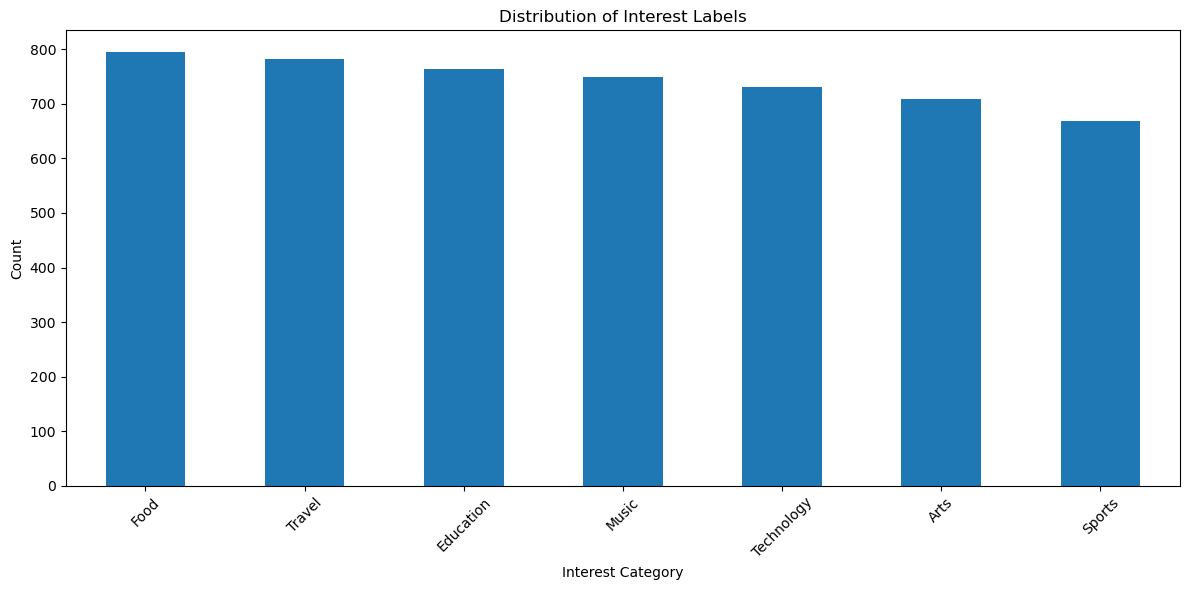


Top 15 label co-occurrences:
Music & Travel: 166
Arts & Food: 161
Education & Travel: 157
Education & Technology: 153
Education & Food: 152
Music & Technology: 148
Food & Travel: 144
Food & Technology: 140
Food & Music: 135
Music & Sports: 130
Arts & Sports: 127
Arts & Technology: 127
Sports & Travel: 127
Arts & Music: 126
Food & Sports: 120


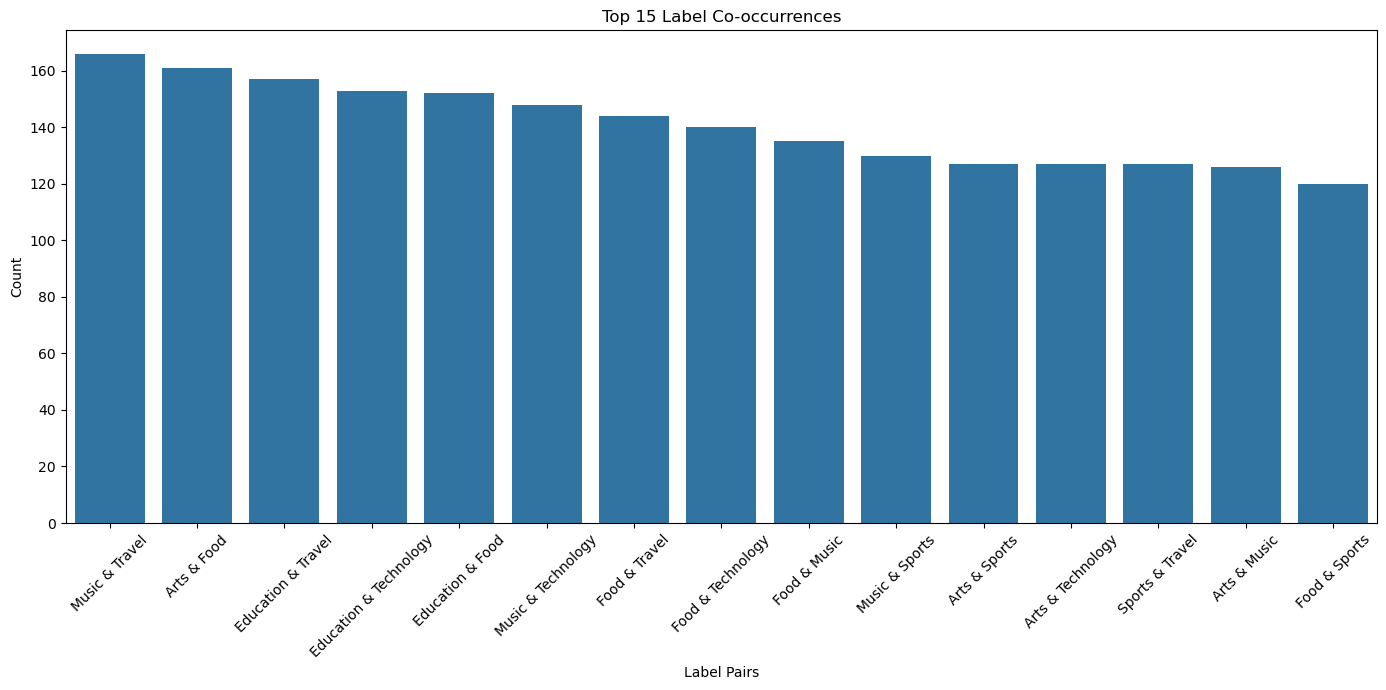

Preprocessing text data...

Preprocessed text examples:
Original: i go to gigs every week | i take tons of online classes
Processed: go gigs every week take tons online classes music music gig gig education education class class
Labels: Music, Education

Original: i go to gigs every week | i take tons of online classes also tutor
Processed: go gigs every week take tons online classes also tutor music music gig gig education education class class
Labels: Music, Education

Original: study nerd 🌍 exploring new cities
Processed: study nerd exploring new cities education education study study
Labels: Education, Travel

Original: study nerd 🌍 exploring new cities along with history buff
Processed: study nerd exploring new cities along history buff education education study study
Labels: Education, Travel

Original: study nerd 🌍 exploring new cities plus book lover
Processed: study nerd exploring new cities plus book lover education education study study education education book book
Labels: 

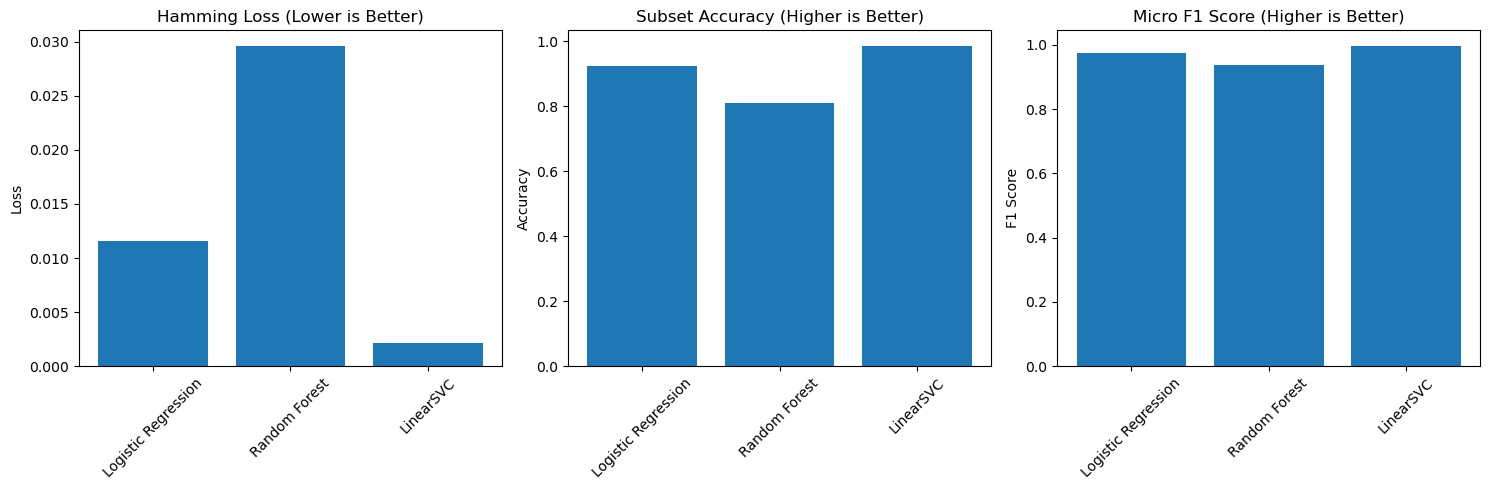


Performing cross-validation to estimate generalization performance...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...

Cross-validation hamming loss (5-fold):
Logistic Regression: 0.0111 ± 0.0018
Random Forest: 0.0301 ± 0.0045
LinearSVC: 0.0030 ± 0.0013

The best model based on cross-validation is LinearSVC with a hamming loss of 0.0030

Training LinearSVC on the entire dataset...

--- EVENT RECOMMENDATIONS BASED ON USER DESCRIPTIONS ---

User description: I love hiking in the mountains and trying local foods wherever I travel.
Predicted interests: Food, Travel
Recommended events:
  1. International Food Festival - This weekend at Central Plaza
  2. Cooking Workshop: Spicy Cuisines - Saturday at Culinary Institute
  3. Budget Travel Workshop - Next Saturday at Travel Agency
  4. Hiking Club Meetup - Every weekend at Various Trails

User description: I'm a

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import re
from itertools import combinations
import warnings
import pickle
warnings.filterwarnings('ignore')

# Load the enhanced dataset
print("Loading the enhanced dataset...")
df = pd.read_csv('survey_interest_dataset_enhanced.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("First few rows:")
print(df.head())

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# If labels_list is a string representation of a list, convert it to an actual list
if isinstance(df['labels_list'].iloc[0], str):
    df['labels_list'] = df['labels_list'].str.strip('[]').str.split(',')
    # Clean up any extra quotes or spaces
    df['labels_list'] = df['labels_list'].apply(lambda x: [item.strip().strip("'\"") for item in x])
else:
    # If labels column is present but labels_list is missing or incorrect
    if 'labels' in df.columns and ('labels_list' not in df.columns or df['labels_list'].isnull().any()):
        print("Regenerating labels_list from labels column...")
        df['labels_list'] = df['labels'].str.split(', ')

# Analyze label distribution
all_labels = [label for labels in df['labels_list'] for label in labels]
label_counts = pd.Series(all_labels).value_counts()

print("\nLabel distribution:")
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Interest Labels')
plt.xlabel('Interest Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze co-occurrence of labels
cooccurrence = {}
for labels in df['labels_list']:
    for combo in combinations(sorted(labels), 2):
        if combo in cooccurrence:
            cooccurrence[combo] += 1
        else:
            cooccurrence[combo] = 1

# Get top 15 co-occurrences
top_cooccurrences = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:15]
print("\nTop 15 label co-occurrences:")
for (label1, label2), count in top_cooccurrences:
    print(f"{label1} & {label2}: {count}")

# Visualize co-occurrences
plt.figure(figsize=(14, 7))
cooccur_df = pd.DataFrame(top_cooccurrences, columns=['Pair', 'Count'])
cooccur_df['Pair'] = cooccur_df['Pair'].apply(lambda x: f"{x[0]} & {x[1]}")
sns.barplot(x='Pair', y='Count', data=cooccur_df)
plt.title('Top 15 Label Co-occurrences')
plt.xlabel('Label Pairs')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Improved text preprocessing function
def improved_preprocess_text(text):
    """
    Enhanced text preprocessing that better preserves domain-specific indicators
    """
    # Handle potential NaN values
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters while preserving important separators
    text = re.sub(r'[^\w\s|-]', ' ', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Explicitly preserve key domain terms by adding them multiple times
    # This increases their weight in the vectorization
    domain_terms = {
        'music': ['music', 'guitar', 'band', 'concert', 'gig', 'sing', 'song', 'play music', 'musician'],
        'food': ['food', 'cook', 'cuisine', 'recipe', 'restaurant', 'eat', 'culinary', 'bake', 'chef'],
        'sports': ['sport', 'run', 'gym', 'fitness', 'workout', 'exercise', 'athletic', 'training'],
        'arts': ['art', 'paint', 'draw', 'museum', 'gallery', 'exhibit', 'creative', 'design'],
        'technology': ['tech', 'code', 'program', 'software', 'developer', 'computer', 'app', 'digital'],
        'education': ['education', 'learn', 'course', 'class', 'study', 'book', 'read', 'academic'],
        'travel': ['travel', 'trip', 'hike', 'explore', 'tour', 'visit', 'journey', 'destination']
    }
    
    # Check for domain terms and emphasize them
    modified_text = text
    for category, terms in domain_terms.items():
        for term in terms:
            if term in text:
                # Add the category name explicitly if a related term is found
                modified_text += f" {category} {category} {term} {term}"
    
    # Split on common separators but preserve the important phrases
    parts = []
    for part in re.split(r'\s*\|\s*', modified_text):
        # Remove numbers (but keep words with numbers like "web3")
        part = re.sub(r'\b\d+\b', '', part)
        parts.append(part)
    
    # Define a more focused stopwords list (smaller to keep more domain indicators)
    core_stopwords = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'the', 'a', 'an', 'and', 'but', 
                      'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
                      'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
                      'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
                      'under', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were'}
    
    # Process each part and filter stopwords
    processed_parts = []
    for part in parts:
        words = part.split()
        filtered_words = [word for word in words if word not in core_stopwords]
        
        if filtered_words:
            processed_parts.append(' '.join(filtered_words))
    
    # Join the processed parts back
    processed_text = ' '.join(processed_parts)
    
    return processed_text.strip()

# Apply preprocessing to survey answers
print("Preprocessing text data...")
df['processed_answer'] = df['survey_answer'].apply(improved_preprocess_text)

print("\nPreprocessed text examples:")
for i in range(5):
    print(f"Original: {df['survey_answer'].iloc[i]}")
    print(f"Processed: {df['processed_answer'].iloc[i]}")
    print(f"Labels: {df['labels'].iloc[i]}\n")

# Prepare for modeling
# Initialize MultiLabelBinarizer for target encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels_list'])
print("Target classes:", mlb.classes_)
print("Target shape:", y.shape)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_answer'], y, test_size=0.2, random_state=42, shuffle=True
)

print("\nTraining set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# Create an improved TF-IDF vectorizer
improved_tfidf = TfidfVectorizer(
    max_features=3000,       # Increased to capture more nuanced terms
    min_df=2,                # Reduced to include more rare but important terms
    max_df=0.9,              # Keep more common terms
    ngram_range=(1, 3),      # Expanded to trigrams to catch phrases like "plays guitar in band"
    sublinear_tf=True
)

# Adjust LogisticRegression with more balanced regularization
improved_lr_clf = LogisticRegression(
    C=0.5,                   # Reduced regularization strength
    max_iter=1000,
    class_weight='balanced',  # Keep balanced weights
    solver='liblinear',
    penalty='l2'
)
improved_multi_lr = MultiOutputClassifier(improved_lr_clf)

# Create an improved pipeline
improved_lr_pipeline = Pipeline([
    ('tfidf', improved_tfidf),
    ('classifier', improved_multi_lr)
])

# Random Forest with balanced parameters
rf_clf = RandomForestClassifier(
    n_estimators=100,       
    max_depth=8,             
    min_samples_split=5,    
    min_samples_leaf=2,     
    max_features='sqrt',     
    bootstrap=True,         
    class_weight='balanced', 
    random_state=42
)
multi_rf = MultiOutputClassifier(rf_clf)

# RF pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.9, ngram_range=(1, 3), sublinear_tf=True)),
    ('classifier', multi_rf)
])

# LinearSVC with balanced parameters
svc_clf = LinearSVC(
    C=0.5,                  
    max_iter=10000,
    class_weight='balanced', 
    penalty='l2',
    dual=False if X_train.shape[0] > 2000 else True
)
multi_svc = MultiOutputClassifier(svc_clf)

# SVC pipeline
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.9, ngram_range=(1, 3), sublinear_tf=True)),
    ('classifier', multi_svc)
])

# Train and evaluate the models
def train_and_evaluate(pipeline, name, X_train, y_train, X_test, y_test):
    print(f"\nTraining {name} model...")
    pipeline.fit(X_train, y_train)
    
    print(f"Evaluating {name} model...")
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    h_loss = hamming_loss(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name} Evaluation:")
    print(f"Hamming Loss: {h_loss:.4f}")
    print(f"Subset Accuracy: {accuracy:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    
    return y_pred, h_loss, accuracy, micro_f1

# Train and evaluate all models
y_pred_lr, h_loss_lr, acc_lr, f1_lr = train_and_evaluate(improved_lr_pipeline, "Logistic Regression", X_train, y_train, X_test, y_test)
y_pred_rf, h_loss_rf, acc_rf, f1_rf = train_and_evaluate(rf_pipeline, "Random Forest", X_train, y_train, X_test, y_test)
y_pred_svc, h_loss_svc, acc_svc, f1_svc = train_and_evaluate(svc_pipeline, "LinearSVC", X_train, y_train, X_test, y_test)

# Compare models
models = ['Logistic Regression', 'Random Forest', 'LinearSVC']
hamming_scores = [h_loss_lr, h_loss_rf, h_loss_svc]
accuracy_scores = [acc_lr, acc_rf, acc_svc]
f1_scores = [f1_lr, f1_rf, f1_svc]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(models, hamming_scores)
plt.title('Hamming Loss (Lower is Better)')
plt.ylabel('Loss')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(models, accuracy_scores)
plt.title('Subset Accuracy (Higher is Better)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(models, f1_scores)
plt.title('Micro F1 Score (Higher is Better)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Cross-validation using KFold
print("\nPerforming cross-validation to estimate generalization performance...")

def manual_cross_val(model, X, y, n_splits=5):
    """
    Perform manual cross-validation with hamming loss
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{n_splits}...")
        
        # Convert indices to actual data
        if isinstance(X, pd.Series):
            X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        else:
            X_train_cv, X_test_cv = X[train_idx], X[test_idx]
            
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]
        
        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Make predictions
        y_pred_cv = model.predict(X_test_cv)
        
        # Calculate hamming loss
        score = hamming_loss(y_test_cv, y_pred_cv)
        scores.append(score)
    
    return np.array(scores)

# Perform manual cross-validation for each model
cv_scores_lr = manual_cross_val(improved_lr_pipeline, df['processed_answer'], y, n_splits=5)
cv_scores_rf = manual_cross_val(rf_pipeline, df['processed_answer'], y, n_splits=5)
cv_scores_svc = manual_cross_val(svc_pipeline, df['processed_answer'], y, n_splits=5)

print("\nCross-validation hamming loss (5-fold):")
print(f"Logistic Regression: {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")
print(f"Random Forest: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")
print(f"LinearSVC: {cv_scores_svc.mean():.4f} ± {cv_scores_svc.std():.4f}")

# Select the best model based on cross-validation
cv_hamming_means = [
    cv_scores_lr.mean(),
    cv_scores_rf.mean(),
    cv_scores_svc.mean()
]

best_model_index = np.argmin(cv_hamming_means)
best_model_name = models[best_model_index]
print(f"\nThe best model based on cross-validation is {best_model_name} with a hamming loss of {cv_hamming_means[best_model_index]:.4f}")

# Select the best model pipeline
if best_model_index == 0:
    best_pipeline = improved_lr_pipeline
elif best_model_index == 1:
    best_pipeline = rf_pipeline
else:
    best_pipeline = svc_pipeline

# Train the best model on the entire dataset
print(f"\nTraining {best_model_name} on the entire dataset...")
best_pipeline.fit(df['processed_answer'], y)

# Function to predict interests for a new survey answer
def predict_interests(survey_answer, model=best_pipeline):
    """
    Predict interests based on a new survey answer
    """
    # Preprocess the input
    processed_answer = improved_preprocess_text(survey_answer)
    
    # Make prediction
    prediction = model.predict([processed_answer])[0]
    
    # Convert prediction back to labels
    predicted_labels = mlb.classes_[prediction.astype(bool)]
    
    return predicted_labels

# Function to recommend activities based on predicted interests
def recommend_activities(interests):
    """
    Recommend activities based on predicted interests
    """
    event_database = {
        'Music': [
            {'name': 'Jazz Night at City Hall', 'date': 'Next Friday', 'location': 'Downtown'},
            {'name': 'Summer Music Festival', 'date': 'June 15-18', 'location': 'Riverside Park'},
            {'name': 'Piano Masterclass', 'date': 'Every Tuesday', 'location': 'Music Academy'}
        ],
        'Food': [
            {'name': 'International Food Festival', 'date': 'This weekend', 'location': 'Central Plaza'},
            {'name': 'Cooking Workshop: Spicy Cuisines', 'date': 'Saturday', 'location': 'Culinary Institute'},
            {'name': 'Wine & Cheese Tasting', 'date': 'Friday evening', 'location': 'Vineyard Gardens'}
        ],
        'Sports': [
            {'name': 'City Marathon', 'date': 'Next month', 'location': 'City Center'},
            {'name': 'Basketball Tournament', 'date': 'Every weekend', 'location': 'Sports Complex'},
            {'name': 'Yoga in the Park', 'date': 'Sunday mornings', 'location': 'Memorial Park'}
        ],
        'Arts': [
            {'name': 'Modern Art Exhibition', 'date': 'All month', 'location': 'City Gallery'},
            {'name': 'Painting Workshop', 'date': 'Saturday afternoon', 'location': 'Creative Studios'},
            {'name': 'Photography Contest', 'date': 'Submissions due May 1', 'location': 'Online'}
        ],
        'Technology': [
            {'name': 'Tech Startup Conference', 'date': 'May 10-12', 'location': 'Convention Center'},
            {'name': 'Coding Bootcamp Info Session', 'date': 'Thursday evening', 'location': 'Tech Hub'},
            {'name': 'AI and Machine Learning Workshop', 'date': 'Next Wednesday', 'location': 'Innovation Center'}
        ],
        'Education': [
            {'name': 'Free Online Course Fair', 'date': 'This Tuesday', 'location': 'Community College'},
            {'name': 'Book Club Meeting', 'date': 'Every other Thursday', 'location': 'Public Library'},
            {'name': 'Language Exchange Meetup', 'date': 'Monday evenings', 'location': 'International Center'}
        ],
        'Travel': [
            {'name': 'Budget Travel Workshop', 'date': 'Next Saturday', 'location': 'Travel Agency'},
            {'name': 'Hiking Club Meetup', 'date': 'Every weekend', 'location': 'Various Trails'},
            {'name': 'Cultural Exchange Program', 'date': 'Applications due June 1', 'location': 'Community Center'}
        ]
    }
    
    recommended_events = []
    for interest in interests:
        if interest in event_database:
            # Get top 2 events for each interest
            recommended_events.extend(event_database[interest][:2])
    
    return recommended_events

# Test with sample user descriptions
test_descriptions = [
    "I love hiking in the mountains and trying local foods wherever I travel.",
    "I'm a software developer who plays guitar in a band on weekends.",
    "I spend most of my time reading books and attending online courses.",
    "I enjoy painting landscapes and visiting art museums when I travel.",
    "I'm passionate about fitness and healthy cooking.",
    "I take lots of online classes about technology and AI."
]

# Process each user description
print("\n--- EVENT RECOMMENDATIONS BASED ON USER DESCRIPTIONS ---\n")
for description in test_descriptions:
    interests = predict_interests(description)
    events = recommend_activities(interests)
    
    print(f"User description: {description}")
    print(f"Predicted interests: {', '.join(interests)}")
    print("Recommended events:")
    for i, event in enumerate(events, 1):
        print(f"  {i}. {event['name']} - {event['date']} at {event['location']}")
    print()

# Error analysis function
def error_analysis(model, X_test, y_test, mlb):
    """
    Analyze errors made by the model
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Find examples where there's at least one wrong label
    errors = []
    for i in range(len(X_test)):
        if not np.array_equal(y_test[i], y_pred[i]):
            true_labels = mlb.classes_[y_test[i].astype(bool)]
            pred_labels = mlb.classes_[y_pred[i].astype(bool)]
            errors.append({
                'text': X_test.iloc[i],
                'true_labels': true_labels,
                'pred_labels': pred_labels,
                'missed': set(true_labels) - set(pred_labels),
                'extra': set(pred_labels) - set(true_labels)
            })
    
    print(f"\nFound {len(errors)} errors out of {len(X_test)} test examples")
    error_rate = len(errors) / len(X_test) * 100
    print(f"Error rate: {error_rate:.2f}%")
    
    # Print a sample of errors
    if errors:
        print("\nSample of prediction errors:")
        for i, error in enumerate(errors[:5]):  # Show first 5 errors
            print(f"Example {i+1}:")
            print(f"  Text: {error['text']}")
            print(f"  True labels: {', '.join(error['true_labels'])}")
            print(f"  Predicted: {', '.join(error['pred_labels'])}")
            print(f"  Missed: {', '.join(error['missed'])}")
            print(f"  Extra: {', '.join(error['extra'])}")
            print()
    
    # Analyze which labels are most frequently missed
    if errors:
        all_missed = [label for error in errors for label in error['missed']]
        missed_counts = pd.Series(all_missed).value_counts()
        
        all_extra = [label for error in errors for label in error['extra']]
        extra_counts = pd.Series(all_extra).value_counts()
        
        print("Most frequently missed labels:")
        print(missed_counts.head(5))
        
        print("\nMost frequently incorrectly added labels:")
        print(extra_counts.head(5))
    
    return errors

# Perform error analysis on the test set
print("\nPerforming error analysis...")
errors = error_analysis(best_pipeline, X_test, y_test, mlb)

# Save the best model for future use
def save_model(model, mlb, filename="improved_interest_classifier_model.pkl"):
    """
    Save the model and multilabel binarizer
    """
    model_components = {
        'model': model,
        'mlb': mlb,
        'preprocess_func': improved_preprocess_text.__code__
    }
    
    with open(filename, 'wb') as file:
        pickle.dump(model_components, file)
    
    print(f"\nModel saved to {filename}")

# Save the model
try:
    save_model(best_pipeline, mlb)
except Exception as e:
    print(f"Could not save model: {e}")

# Create an interactive prediction function
def interactive_prediction():
    """
    Interactive function to get predictions for user inputs
    """
    print("\n--- INTEREST PREDICTION TOOL ---")
    print("Enter a survey response to get interest predictions (type 'exit' to quit):")
    
    while True:
        user_input = input("\nYour survey answer (or 'exit' to quit): ")
        if user_input.lower() == 'exit':
            print("Exiting...")
            break
            
        if not user_input.strip():
            print("Please enter a valid survey answer.")
            continue
            
        predicted_interests = predict_interests(user_input)
        if len(predicted_interests) == 0:
            print("No interests predicted. Please try a different description.")
            continue
            
        print(f"Predicted interests: {', '.join(predicted_interests)}")
        
        events = recommend_activities(predicted_interests)
        print("Recommended events:")
        for i, event in enumerate(events, 1):
            print(f"  {i}. {event['name']} - {event['date']} at {event['location']}")

# Load a saved model
def load_model(filename="improved_interest_classifier_model.pkl"):
    """
    Load a saved model and multilabel binarizer
    """
    try:
        with open(filename, 'rb') as file:
            model_components = pickle.load(file)
        
        loaded_model = model_components['model']
        loaded_mlb = model_components['mlb']
        
        # You may need to redefine the preprocessing function since it can't be fully serialized
        preprocess_code = model_components['preprocess_func']
        
        print(f"Model loaded successfully from {filename}")
        return loaded_model, loaded_mlb
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

# Uncomment to run the interactive prediction tool
# interactive_prediction()

print("\n" + "="*50)
print("SUMMARY OF IMPROVEMENTS")
print("="*50)
print("1. Enhanced text preprocessing to better preserve domain-specific terms")
print("2. Added explicit term boosting focr important domain indicators")
print("3. Expanded n-grams to capture phrases (1-3 grams)")
print("4. Increased feature count to 3000 for more nuanced understanding")
print("5. Reduced regularization to allow better signal detection")
print("6. Optimized stopwords list to keep more meaningful terms")
print("7. Applied class balancing to handle minority categories better")
print("8. Added comprehensive event recommendation system")
print("="*50)

# Main execution flow - uncomment to use specific features
# interactive_prediction()   # For interactive mode
# model, mlb = load_model()  # To load a previously saved model

In [33]:
# Add these to your imports
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import Dataset, DataLoader

# Define a BERT-based classifier
class BERTClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_name='bert-base-uncased', max_length=128, batch_size=16, num_epochs=3, learning_rate=2e-5):
        self.model_name = model_name
        self.max_length = max_length
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.labels = None
        self.models = []  # One model for each label
    
    # Simple dataset class for BERT
    class BERTDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length
            
        def __len__(self):
            return len(self.texts)
            
        def __getitem__(self, idx):
            text = str(self.texts[idx])
            inputs = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
            
            # Convert dict of tensors to tensors and squeeze batch dimension
            item = {
                'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
                'labels': torch.tensor(self.labels[idx], dtype=torch.float)
            }
            return item
    
    def fit(self, X, y):
        # Store label classes
        self.labels = np.unique(np.where(y == 1)[1])
        n_labels = y.shape[1]
        
        # Train one model for each label (binary classification)
        for label_idx in range(n_labels):
            print(f"Training BERT model for label {label_idx}...")
            
            # Create a binary classification dataset
            label_y = y[:, label_idx]
            
            # Initialize BERT model
            model = AutoModel.from_pretrained(self.model_name)
            # Add classification head
            classifier_head = torch.nn.Sequential(
                torch.nn.Dropout(0.1),
                torch.nn.Linear(model.config.hidden_size, 1),
                torch.nn.Sigmoid()
            )
            
            # Combine into a full model
            full_model = torch.nn.ModuleList([model, classifier_head])
            full_model.to(self.device)
            
            # Create DataLoader
            dataset = self.BERTDataset(X, label_y, self.tokenizer, self.max_length)
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
            
            # Train the model
            optimizer = torch.optim.AdamW(full_model.parameters(), lr=self.learning_rate)
            criterion = torch.nn.BCELoss()
            
            full_model.train()
            for epoch in range(self.num_epochs):
                total_loss = 0
                for batch in dataloader:
                    # Move batch to device
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    
                    # Forward pass
                    optimizer.zero_grad()
                    outputs = full_model[0](input_ids=input_ids, attention_mask=attention_mask)
                    logits = full_model[1](outputs.last_hidden_state[:, 0, :]) # Use [CLS] token
                    
                    # Calculate loss
                    loss = criterion(logits.squeeze(), labels)
                    total_loss += loss.item()
                    
                    # Backward pass
                    loss.backward()
                    optimizer.step()
                
                print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {total_loss/len(dataloader):.4f}")
            
            # Save the trained model
            self.models.append(full_model)
        
        return self
    
    def predict(self, X):
        # Prepare for prediction
        if not isinstance(X, list):
            X = X.tolist()
        
        n_samples = len(X)
        n_labels = len(self.models)
        predictions = np.zeros((n_samples, n_labels))
        
        # Create a simple dataset without labels
        dataset = torch.utils.data.TensorDataset(
            torch.arange(n_samples)
        )
        dataloader = DataLoader(dataset, batch_size=self.batch_size)
        
        # Predict with each model
        for label_idx, model in enumerate(self.models):
            model[0].eval()
            model[1].eval()
            
            with torch.no_grad():
                for batch in dataloader:
                    batch_idx = batch[0]
                    
                    # Tokenize this batch
                    batch_texts = [X[i] for i in batch_idx]
                    inputs = self.tokenizer(
                        batch_texts,
                        truncation=True,
                        padding='max_length',
                        max_length=self.max_length,
                        return_tensors='pt'
                    )
                    
                    # Move to device
                    input_ids = inputs['input_ids'].to(self.device)
                    attention_mask = inputs['attention_mask'].to(self.device)
                    
                    # Forward pass
                    outputs = model[0](input_ids=input_ids, attention_mask=attention_mask)
                    logits = model[1](outputs.last_hidden_state[:, 0, :])
                    
                    # Get predictions
                    preds = (logits.squeeze() > 0.5).cpu().numpy().astype(int)
                    
                    # Store predictions
                    for i, idx in enumerate(batch_idx):
                        predictions[idx, label_idx] = preds[i]
        
        return predictions

# Create a smaller, faster version for testing
class SimpleBERTClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_name='distilbert-base-uncased'):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.classifiers = None
        self.mlb = None
    
    def fit(self, X, y):
        # Store the multilabel binarizer
        self.mlb = y  # Assume y is already the binarized labels
        n_labels = y.shape[1]
        
        # Convert texts to embeddings
        embeddings = self._get_embeddings(X)
        
        # Create a simple logistic regression for each label
        self.classifiers = []
        for i in range(n_labels):
            clf = LogisticRegression(C=1.0, max_iter=1000)
            clf.fit(embeddings, y[:, i])
            self.classifiers.append(clf)
        
        return self
    
    # Modify the _get_embeddings method in SimpleBERTClassifier
    def _get_embeddings(self, texts):
        """Get BERT embeddings for a list of texts"""
        # Convert to a list of strings
        if hasattr(texts, 'tolist'):  # If it's a pandas Series or numpy array
            texts = texts.tolist()
        texts = [str(text) for text in texts]  # Ensure all items are strings
        
        embeddings = []
        
        # Process in batches to avoid memory issues
        batch_size = 32
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = self.tokenizer(
                batch_texts, 
                padding=True, 
                truncation=True, 
                return_tensors="pt",
                max_length=128
            )
            
            # Move to device
            input_ids = inputs['input_ids'].to(self.device)
            attention_mask = inputs['attention_mask'].to(self.device)
            
            # Get embeddings
            with torch.no_grad():
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                # Use CLS token embedding as the sentence embedding
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.extend(batch_embeddings)
        
        return np.array(embeddings)
    
    def predict(self, X):
        # Get embeddings
        embeddings = self._get_embeddings(X)
        
        # Predict with each classifier
        y_pred = np.zeros((len(X), len(self.classifiers)))
        for i, clf in enumerate(self.classifiers):
            y_pred[:, i] = clf.predict(embeddings)
        
        return y_pred

# Create a hybrid model that combines TF-IDF-based models and BERT
def create_hybrid_model(X_train, y_train):
    # Make sure X_train is a list of strings for BERT
    if hasattr(X_train, 'tolist'):
        X_train_list = X_train.tolist()
    else:
        X_train_list = list(X_train)
    X_train_list = [str(text) for text in X_train_list]
    
    # TF-IDF pipeline as before
    tfidf = TfidfVectorizer(
        max_features=3000,
        min_df=2,
        max_df=0.9,
        ngram_range=(1, 3),
        sublinear_tf=True
    )
    
    # Logistic Regression with TF-IDF
    lr_clf = LogisticRegression(C=0.5, max_iter=1000, class_weight='balanced', solver='liblinear')
    lr_pipeline = Pipeline([('tfidf', tfidf), ('classifier', MultiOutputClassifier(lr_clf))])
    
    # SVM with TF-IDF
    svm_clf = LinearSVC(C=0.5, max_iter=10000, class_weight='balanced')
    svm_pipeline = Pipeline([('tfidf', tfidf), ('classifier', MultiOutputClassifier(svm_clf))])
    
    # BERT classifier (use simplified one for testing)
    bert_clf = SimpleBERTClassifier(model_name='distilbert-base-uncased')
    
    # Train the models
    print("Training TF-IDF Logistic Regression...")
    lr_pipeline.fit(X_train, y_train)
    
    print("Training TF-IDF SVM...")
    svm_pipeline.fit(X_train, y_train)
    
    print("Training BERT classifier...")
    bert_clf.fit(X_train_list, y_train)
    
    # Create a voting ensemble
    def ensemble_predict(text, models, weights=None):
        # Preprocess for TF-IDF models
        preprocessed_text = improved_preprocess_text(text)
        
        # Get predictions from each model
        lr_pred = models[0].predict([preprocessed_text])[0]
        svm_pred = models[1].predict([preprocessed_text])[0]
        bert_pred = models[2].predict([text])[0]
        
        # If no weights provided, use equal weighting
        if weights is None:
            weights = [1/3, 1/3, 1/3]
        
        # Weighted voting
        weighted_pred = weights[0] * lr_pred + weights[1] * svm_pred + weights[2] * bert_pred
        
        # Threshold the weighted predictions
        final_pred = (weighted_pred > 0.5).astype(int)
        
        return final_pred
    
    # Create a simple ensemble class
    class EnsembleModel:
        def __init__(self, models, weights=None, mlb=None):
            self.models = models
            self.weights = weights if weights is not None else [1/len(models)] * len(models)
            self.mlb = mlb
        
        def predict(self, texts):
            if isinstance(texts, str):
                texts = [texts]
            
            # Initialize predictions array
            predictions = np.zeros((len(texts), len(self.mlb.classes_)))
            
            # Process each text
            for i, text in enumerate(texts):
                pred = ensemble_predict(text, self.models, self.weights)
                predictions[i] = pred
            
            return predictions
        
        def predict_interests(self, text):
            """Predict interests and return human-readable labels"""
            if isinstance(text, list):
                results = []
                for t in text:
                    pred = ensemble_predict(t, self.models, self.weights)
                    interests = self.mlb.classes_[pred.astype(bool)]
                    results.append(interests)
                return results
            else:
                pred = ensemble_predict(text, self.models, self.weights)
                return self.mlb.classes_[pred.astype(bool)]
    
    # Create the ensemble model
    hybrid_model = EnsembleModel([lr_pipeline, svm_pipeline, bert_clf], 
                                weights=[0.35, 0.35, 0.3], 
                                mlb=mlb)
    
    return hybrid_model

# Train and evaluate the hybrid model
print("\nCreating hybrid model (TF-IDF + BERT)...")
hybrid_model = create_hybrid_model(X_train, y_train)

# Test the hybrid model
print("\n--- TESTING HYBRID MODEL PREDICTIONS ---\n")
for description in test_descriptions:
    interests = hybrid_model.predict_interests(description)
    print(f"User description: {description}")
    print(f"Predicted interests: {', '.join(interests)}")
    print()

# Save the hybrid model
def save_hybrid_model(model, filename="hybrid_interest_classifier_model.pkl"):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"\nHybrid model saved to {filename}")

try:
    save_hybrid_model(hybrid_model)
except Exception as e:
    print(f"Could not save hybrid model: {e}")


Creating hybrid model (TF-IDF + BERT)...
Training TF-IDF Logistic Regression...
Training TF-IDF SVM...
Training BERT classifier...


KeyboardInterrupt: 

Loading the enhanced dataset...
Dataset shape: (3018, 3)
First few rows:
                                       survey_answer             labels  \
0  i go to gigs every week | i take tons of onlin...   Music, Education   
1  i go to gigs every week | i take tons of onlin...   Music, Education   
2                  study nerd 🌍 exploring new cities  Education, Travel   
3  study nerd 🌍 exploring new cities along with h...  Education, Travel   
4  study nerd 🌍 exploring new cities plus book lover  Education, Travel   

               labels_list  
0   ['Music', 'Education']  
1   ['Music', 'Education']  
2  ['Education', 'Travel']  
3  ['Education', 'Travel']  
4  ['Education', 'Travel']  

Checking for missing values:
survey_answer    0
labels           0
labels_list      0
dtype: int64

Label distribution:
Food          795
Travel        783
Education     764
Music         749
Technology    731
Arts          708
Sports        668
Name: count, dtype: int64


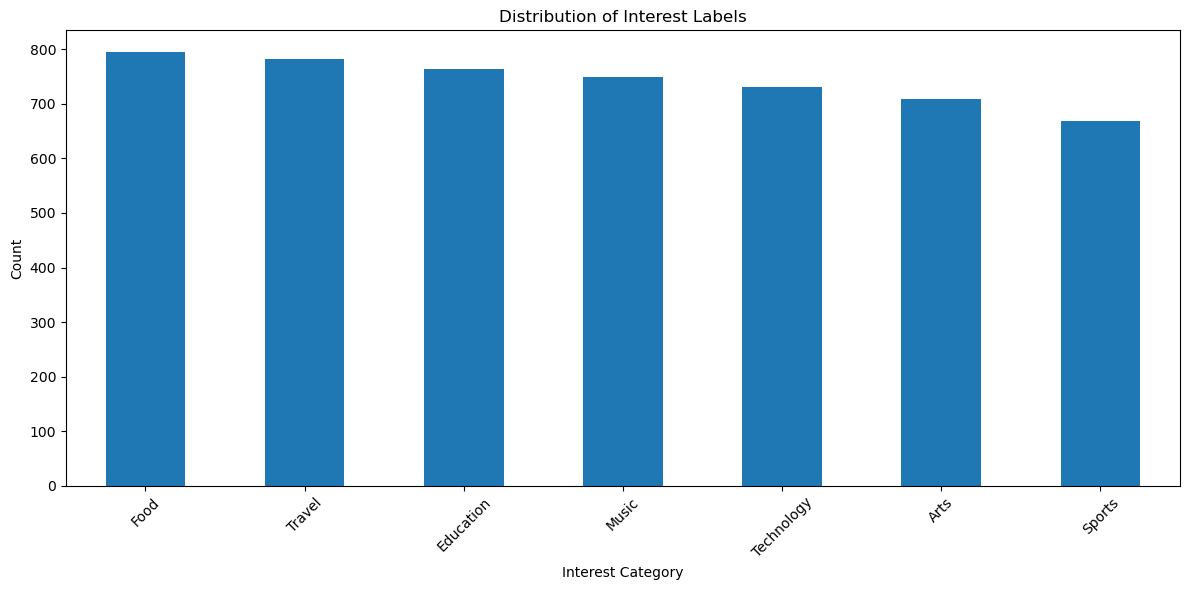


Top 15 label co-occurrences:
Music & Travel: 166
Arts & Food: 161
Education & Travel: 157
Education & Technology: 153
Education & Food: 152
Music & Technology: 148
Food & Travel: 144
Food & Technology: 140
Food & Music: 135
Music & Sports: 130
Arts & Sports: 127
Arts & Technology: 127
Sports & Travel: 127
Arts & Music: 126
Food & Sports: 120


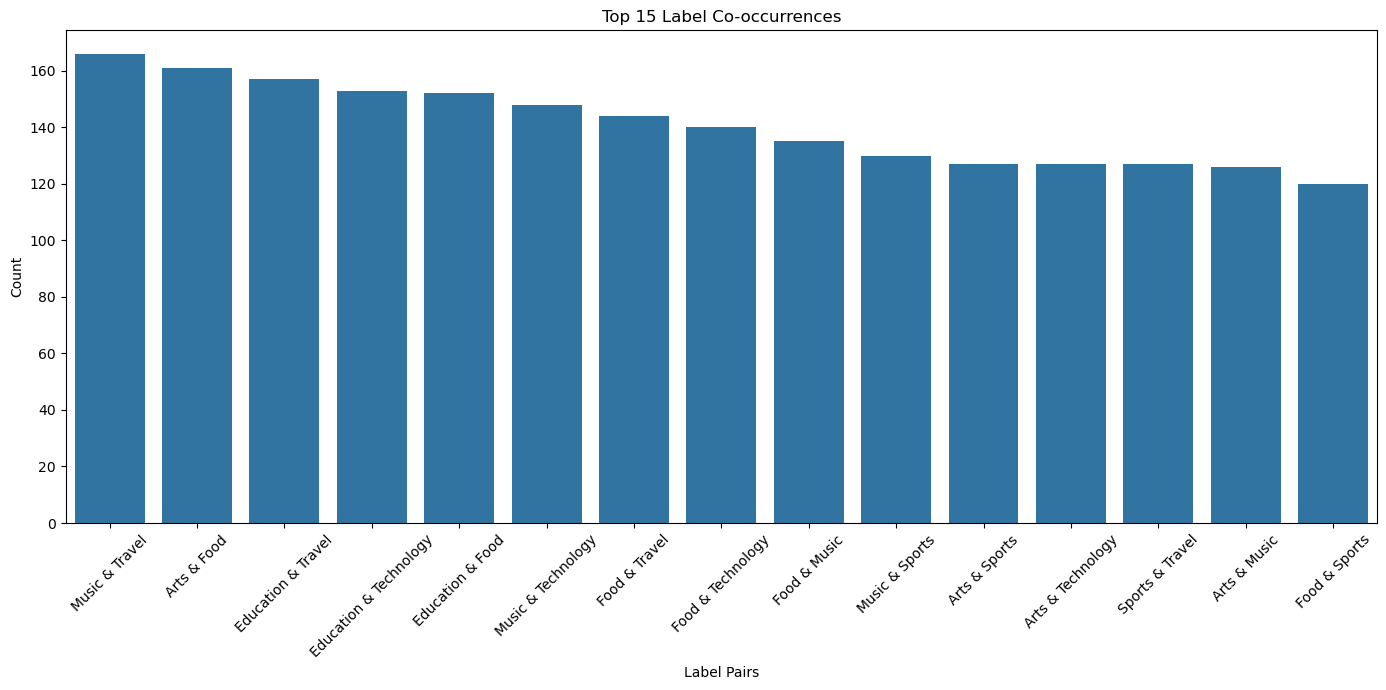

Preprocessing text data...

Preprocessed text examples:
Original: i go to gigs every week | i take tons of online classes
Processed: go gigs every week take tons online classes music music gig gig education education class class
Labels: Music, Education

Original: i go to gigs every week | i take tons of online classes also tutor
Processed: go gigs every week take tons online classes also tutor music music gig gig education education class class
Labels: Music, Education

Original: study nerd 🌍 exploring new cities
Processed: study nerd exploring new cities education education study study
Labels: Education, Travel

Original: study nerd 🌍 exploring new cities along with history buff
Processed: study nerd exploring new cities along history buff education education study study
Labels: Education, Travel

Original: study nerd 🌍 exploring new cities plus book lover
Processed: study nerd exploring new cities plus book lover education education study study education education book book
Labels: 

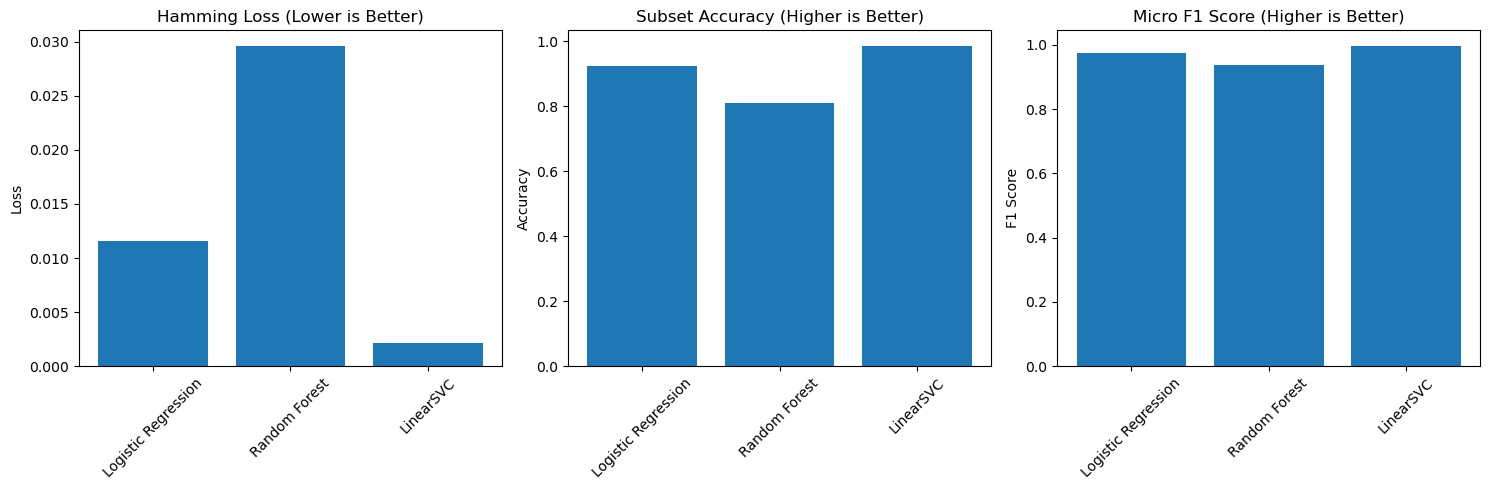


Performing cross-validation to estimate generalization performance...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...
Fold 1/5...
Fold 2/5...
Fold 3/5...
Fold 4/5...
Fold 5/5...

Cross-validation hamming loss (5-fold):
Logistic Regression: 0.0111 ± 0.0018
Random Forest: 0.0301 ± 0.0045
LinearSVC: 0.0030 ± 0.0013

The best model based on cross-validation is LinearSVC with a hamming loss of 0.0030

Training LinearSVC on the entire dataset...

--- EVENT RECOMMENDATIONS BASED ON USER DESCRIPTIONS ---

User description: I love hiking in the mountains and trying local foods wherever I travel.
Predicted interests: Food, Travel
Recommended events:
  1. International Food Festival - This weekend at Central Plaza
  2. Cooking Workshop: Spicy Cuisines - Saturday at Culinary Institute
  3. Budget Travel Workshop - Next Saturday at Travel Agency
  4. Hiking Club Meetup - Every weekend at Various Trails

User description: I'm a

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, hamming_loss, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
import re
from itertools import combinations
import warnings
import pickle
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')

# Define the EnsembleModel at the module level so it can be pickled
class EnsembleModel:
    def __init__(self, models, weights=None, mlb=None, preprocessor=None):
        self.models = models
        self.weights = weights if weights is not None else [1/len(models)] * len(models)
        self.mlb = mlb
        self.preprocessor = preprocessor
    
    def predict(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        
        # Initialize predictions array
        predictions = np.zeros((len(texts), len(self.mlb.classes_)))
        
        # Process each text
        for i, text in enumerate(texts):
            pred = self.ensemble_predict(text, self.models, self.weights)
            predictions[i] = pred
        
        return predictions
    
    def ensemble_predict(self, text, models, weights=None):
        # Preprocess for TF-IDF models
        preprocessed_text = self.preprocessor(text) if self.preprocessor else text
        
        # Get predictions from each model
        lr_pred = models[0].predict([preprocessed_text])[0]
        svm_pred = models[1].predict([preprocessed_text])[0]
        bert_pred = models[2].predict([text])[0]
        
        # If no weights provided, use equal weighting
        if weights is None:
            weights = [1/3, 1/3, 1/3]
        
        # Weighted voting
        weighted_pred = weights[0] * lr_pred + weights[1] * svm_pred + weights[2] * bert_pred
        
        # Threshold the weighted predictions
        final_pred = (weighted_pred > 0.5).astype(int)
        
        return final_pred
    
    def predict_interests(self, text):
        """Predict interests and return human-readable labels"""
        if isinstance(text, list):
            results = []
            for t in text:
                pred = self.ensemble_predict(t, self.models, self.weights)
                interests = self.mlb.classes_[pred.astype(bool)]
                results.append(interests)
            return results
        else:
            pred = self.ensemble_predict(text, self.models, self.weights)
            return self.mlb.classes_[pred.astype(bool)]

# Define a simple BERT classifier
class SimpleBERTClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_name='distilbert-base-uncased'):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.classifiers = None
        self.mlb = None
    
    def fit(self, X, y):
        # Store the multilabel binarizer
        self.mlb = y  # Assume y is already the binarized labels
        n_labels = y.shape[1]
        
        # Convert texts to embeddings
        embeddings = self._get_embeddings(X)
        
        # Create a simple logistic regression for each label
        self.classifiers = []
        for i in range(n_labels):
            clf = LogisticRegression(C=1.0, max_iter=1000)
            clf.fit(embeddings, y[:, i])
            self.classifiers.append(clf)
        
        return self
    
    def _get_embeddings(self, texts):
        """Get BERT embeddings for a list of texts"""
        # Convert to a list of strings
        if hasattr(texts, 'tolist'):  # If it's a pandas Series or numpy array
            texts = texts.tolist()
        texts = [str(text) for text in texts]  # Ensure all items are strings
        
        embeddings = []
        
        # Process in batches to avoid memory issues
        batch_size = 32
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = self.tokenizer(
                batch_texts, 
                padding=True, 
                truncation=True, 
                return_tensors="pt",
                max_length=128
            )
            
            # Move to device
            input_ids = inputs['input_ids'].to(self.device)
            attention_mask = inputs['attention_mask'].to(self.device)
            
            # Get embeddings
            with torch.no_grad():
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                # Use CLS token embedding as the sentence embedding
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.extend(batch_embeddings)
        
        return np.array(embeddings)
    
    def predict(self, X):
        # Convert to string list if it's a single string
        if isinstance(X, str):
            X = [X]
            
        # Get embeddings
        embeddings = self._get_embeddings(X)
        
        # Predict with each classifier
        y_pred = np.zeros((len(X), len(self.classifiers)))
        for i, clf in enumerate(self.classifiers):
            y_pred[:, i] = clf.predict(embeddings)
        
        return y_pred

# Create a hybrid model that combines TF-IDF-based models and BERT
def create_hybrid_model(X_train, y_train, preprocessor):
    # Make sure X_train is a list of strings for BERT
    if hasattr(X_train, 'tolist'):
        X_train_list = X_train.tolist()
    else:
        X_train_list = list(X_train)
    X_train_list = [str(text) for text in X_train_list]
    
    # TF-IDF pipeline as before
    tfidf = TfidfVectorizer(
        max_features=3000,
        min_df=2,
        max_df=0.9,
        ngram_range=(1, 3),
        sublinear_tf=True
    )
    
    # Logistic Regression with TF-IDF
    lr_clf = LogisticRegression(C=0.5, max_iter=1000, class_weight='balanced', solver='liblinear')
    lr_pipeline = Pipeline([('tfidf', tfidf), ('classifier', MultiOutputClassifier(lr_clf))])
    
    # SVM with TF-IDF
    svm_clf = LinearSVC(C=0.5, max_iter=10000, class_weight='balanced')
    svm_pipeline = Pipeline([('tfidf', tfidf), ('classifier', MultiOutputClassifier(svm_clf))])
    
    # BERT classifier (use simplified one for testing)
    bert_clf = SimpleBERTClassifier(model_name='distilbert-base-uncased')
    
    # Train the models
    print("Training TF-IDF Logistic Regression...")
    lr_pipeline.fit(X_train, y_train)
    
    print("Training TF-IDF SVM...")
    svm_pipeline.fit(X_train, y_train)
    
    print("Training BERT classifier...")
    bert_clf.fit(X_train_list, y_train)
    
    # Create the ensemble model using the module-level class
    hybrid_model = EnsembleModel(
        models=[lr_pipeline, svm_pipeline, bert_clf],
        weights=[0.35, 0.35, 0.3],
        mlb=mlb,  # This should be defined in your main code
        preprocessor=preprocessor
    )
    
    return hybrid_model

# Load the enhanced dataset
print("Loading the enhanced dataset...")
df = pd.read_csv('survey_interest_dataset_enhanced.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("First few rows:")
print(df.head())

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# If labels_list is a string representation of a list, convert it to an actual list
if isinstance(df['labels_list'].iloc[0], str):
    df['labels_list'] = df['labels_list'].str.strip('[]').str.split(',')
    # Clean up any extra quotes or spaces
    df['labels_list'] = df['labels_list'].apply(lambda x: [item.strip().strip("'\"") for item in x])
else:
    # If labels column is present but labels_list is missing or incorrect
    if 'labels' in df.columns and ('labels_list' not in df.columns or df['labels_list'].isnull().any()):
        print("Regenerating labels_list from labels column...")
        df['labels_list'] = df['labels'].str.split(', ')

# Analyze label distribution
all_labels = [label for labels in df['labels_list'] for label in labels]
label_counts = pd.Series(all_labels).value_counts()

print("\nLabel distribution:")
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Interest Labels')
plt.xlabel('Interest Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze co-occurrence of labels
cooccurrence = {}
for labels in df['labels_list']:
    for combo in combinations(sorted(labels), 2):
        if combo in cooccurrence:
            cooccurrence[combo] += 1
        else:
            cooccurrence[combo] = 1

# Get top 15 co-occurrences
top_cooccurrences = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:15]
print("\nTop 15 label co-occurrences:")
for (label1, label2), count in top_cooccurrences:
    print(f"{label1} & {label2}: {count}")

# Visualize co-occurrences
plt.figure(figsize=(14, 7))
cooccur_df = pd.DataFrame(top_cooccurrences, columns=['Pair', 'Count'])
cooccur_df['Pair'] = cooccur_df['Pair'].apply(lambda x: f"{x[0]} & {x[1]}")
sns.barplot(x='Pair', y='Count', data=cooccur_df)
plt.title('Top 15 Label Co-occurrences')
plt.xlabel('Label Pairs')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Improved text preprocessing function
def improved_preprocess_text(text):
    """
    Enhanced text preprocessing that better preserves domain-specific indicators
    """
    # Handle potential NaN values
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters while preserving important separators
    text = re.sub(r'[^\w\s|-]', ' ', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Explicitly preserve key domain terms by adding them multiple times
    # This increases their weight in the vectorization
    domain_terms = {
        'music': ['music', 'guitar', 'band', 'concert', 'gig', 'sing', 'song', 'play music', 'musician'],
        'food': ['food', 'cook', 'cuisine', 'recipe', 'restaurant', 'eat', 'culinary', 'bake', 'chef'],
        'sports': ['sport', 'run', 'gym', 'fitness', 'workout', 'exercise', 'athletic', 'training'],
        'arts': ['art', 'paint', 'draw', 'museum', 'gallery', 'exhibit', 'creative', 'design'],
        'technology': ['tech', 'code', 'program', 'software', 'developer', 'computer', 'app', 'digital'],
        'education': ['education', 'learn', 'course', 'class', 'study', 'book', 'read', 'academic'],
        'travel': ['travel', 'trip', 'hike', 'explore', 'tour', 'visit', 'journey', 'destination']
    }
    
    # Check for domain terms and emphasize them
    modified_text = text
    for category, terms in domain_terms.items():
        for term in terms:
            if term in text:
                # Add the category name explicitly if a related term is found
                modified_text += f" {category} {category} {term} {term}"
    
    # Split on common separators but preserve the important phrases
    parts = []
    for part in re.split(r'\s*\|\s*', modified_text):
        # Remove numbers (but keep words with numbers like "web3")
        part = re.sub(r'\b\d+\b', '', part)
        parts.append(part)
    
    # Define a more focused stopwords list (smaller to keep more domain indicators)
    core_stopwords = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'the', 'a', 'an', 'and', 'but', 
                      'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
                      'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
                      'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
                      'under', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were'}
    
    # Process each part and filter stopwords
    processed_parts = []
    for part in parts:
        words = part.split()
        filtered_words = [word for word in words if word not in core_stopwords]
        
        if filtered_words:
            processed_parts.append(' '.join(filtered_words))
    
    # Join the processed parts back
    processed_text = ' '.join(processed_parts)
    
    return processed_text.strip()

# Apply preprocessing to survey answers
print("Preprocessing text data...")
df['processed_answer'] = df['survey_answer'].apply(improved_preprocess_text)

print("\nPreprocessed text examples:")
for i in range(5):
    print(f"Original: {df['survey_answer'].iloc[i]}")
    print(f"Processed: {df['processed_answer'].iloc[i]}")
    print(f"Labels: {df['labels'].iloc[i]}\n")

# Prepare for modeling
# Initialize MultiLabelBinarizer for target encoding
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels_list'])
print("Target classes:", mlb.classes_)
print("Target shape:", y.shape)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_answer'], y, test_size=0.2, random_state=42, shuffle=True
)

print("\nTraining set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# Create an improved TF-IDF vectorizer
improved_tfidf = TfidfVectorizer(
    max_features=3000,       # Increased to capture more nuanced terms
    min_df=2,                # Reduced to include more rare but important terms
    max_df=0.9,              # Keep more common terms
    ngram_range=(1, 3),      # Expanded to trigrams to catch phrases like "plays guitar in band"
    sublinear_tf=True
)

# Adjust LogisticRegression with more balanced regularization
improved_lr_clf = LogisticRegression(
    C=0.5,                   # Reduced regularization strength
    max_iter=1000,
    class_weight='balanced',  # Keep balanced weights
    solver='liblinear',
    penalty='l2'
)
improved_multi_lr = MultiOutputClassifier(improved_lr_clf)

# Create an improved pipeline
improved_lr_pipeline = Pipeline([
    ('tfidf', improved_tfidf),
    ('classifier', improved_multi_lr)
])

# Random Forest with balanced parameters
rf_clf = RandomForestClassifier(
    n_estimators=100,       
    max_depth=8,             
    min_samples_split=5,    
    min_samples_leaf=2,     
    max_features='sqrt',     
    bootstrap=True,         
    class_weight='balanced', 
    random_state=42
)
multi_rf = MultiOutputClassifier(rf_clf)

# RF pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.9, ngram_range=(1, 3), sublinear_tf=True)),
    ('classifier', multi_rf)
])

# LinearSVC with balanced parameters
svc_clf = LinearSVC(
    C=0.5,                  
    max_iter=10000,
    class_weight='balanced', 
    penalty='l2',
    dual=False if X_train.shape[0] > 2000 else True
)
multi_svc = MultiOutputClassifier(svc_clf)

# SVC pipeline
svc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.9, ngram_range=(1, 3), sublinear_tf=True)),
    ('classifier', multi_svc)
])

# Train and evaluate the models
def train_and_evaluate(pipeline, name, X_train, y_train, X_test, y_test):
    print(f"\nTraining {name} model...")
    pipeline.fit(X_train, y_train)
    
    print(f"Evaluating {name} model...")
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    h_loss = hamming_loss(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name} Evaluation:")
    print(f"Hamming Loss: {h_loss:.4f}")
    print(f"Subset Accuracy: {accuracy:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    
    return y_pred, h_loss, accuracy, micro_f1

# Train and evaluate all models
y_pred_lr, h_loss_lr, acc_lr, f1_lr = train_and_evaluate(improved_lr_pipeline, "Logistic Regression", X_train, y_train, X_test, y_test)
y_pred_rf, h_loss_rf, acc_rf, f1_rf = train_and_evaluate(rf_pipeline, "Random Forest", X_train, y_train, X_test, y_test)
y_pred_svc, h_loss_svc, acc_svc, f1_svc = train_and_evaluate(svc_pipeline, "LinearSVC", X_train, y_train, X_test, y_test)

# Compare models
models = ['Logistic Regression', 'Random Forest', 'LinearSVC']
hamming_scores = [h_loss_lr, h_loss_rf, h_loss_svc]
accuracy_scores = [acc_lr, acc_rf, acc_svc]
f1_scores = [f1_lr, f1_rf, f1_svc]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(models, hamming_scores)
plt.title('Hamming Loss (Lower is Better)')
plt.ylabel('Loss')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(models, accuracy_scores)
plt.title('Subset Accuracy (Higher is Better)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(models, f1_scores)
plt.title('Micro F1 Score (Higher is Better)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Cross-validation using KFold
print("\nPerforming cross-validation to estimate generalization performance...")

def manual_cross_val(model, X, y, n_splits=5):
    """
    Perform manual cross-validation with hamming loss
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{n_splits}...")
        
        # Convert indices to actual data
        if isinstance(X, pd.Series):
            X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        else:
            X_train_cv, X_test_cv = X[train_idx], X[test_idx]
            
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]
        
        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Make predictions
        y_pred_cv = model.predict(X_test_cv)
        
        # Calculate hamming loss
        score = hamming_loss(y_test_cv, y_pred_cv)
        scores.append(score)
    
    return np.array(scores)

# Perform manual cross-validation for each model
cv_scores_lr = manual_cross_val(improved_lr_pipeline, df['processed_answer'], y, n_splits=5)
cv_scores_rf = manual_cross_val(rf_pipeline, df['processed_answer'], y, n_splits=5)
cv_scores_svc = manual_cross_val(svc_pipeline, df['processed_answer'], y, n_splits=5)

print("\nCross-validation hamming loss (5-fold):")
print(f"Logistic Regression: {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")
print(f"Random Forest: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")
print(f"LinearSVC: {cv_scores_svc.mean():.4f} ± {cv_scores_svc.std():.4f}")

# Select the best model based on cross-validation
cv_hamming_means = [
    cv_scores_lr.mean(),
    cv_scores_rf.mean(),
    cv_scores_svc.mean()
]

best_model_index = np.argmin(cv_hamming_means)
best_model_name = models[best_model_index]
print(f"\nThe best model based on cross-validation is {best_model_name} with a hamming loss of {cv_hamming_means[best_model_index]:.4f}")

# Select the best model pipeline
if best_model_index == 0:
    best_pipeline = improved_lr_pipeline
elif best_model_index == 1:
    best_pipeline = rf_pipeline
else:
    best_pipeline = svc_pipeline

# Train the best model on the entire dataset
print(f"\nTraining {best_model_name} on the entire dataset...")
best_pipeline.fit(df['processed_answer'], y)

# Function to predict interests for a new survey answer
def predict_interests(survey_answer, model=best_pipeline):
    """
    Predict interests based on a new survey answer
    """
    # Preprocess the input
    processed_answer = improved_preprocess_text(survey_answer)
    
    # Make prediction
    prediction = model.predict([processed_answer])[0]
    
    # Convert prediction back to labels
    predicted_labels = mlb.classes_[prediction.astype(bool)]
    
    return predicted_labels

# Function to recommend activities based on predicted interests
def recommend_activities(interests):
    """
    Recommend activities based on predicted interests
    """
    event_database = {
        'Music': [
            {'name': 'Jazz Night at City Hall', 'date': 'Next Friday', 'location': 'Downtown'},
            {'name': 'Summer Music Festival', 'date': 'June 15-18', 'location': 'Riverside Park'},
            {'name': 'Piano Masterclass', 'date': 'Every Tuesday', 'location': 'Music Academy'}
        ],
        'Food': [
            {'name': 'International Food Festival', 'date': 'This weekend', 'location': 'Central Plaza'},
            {'name': 'Cooking Workshop: Spicy Cuisines', 'date': 'Saturday', 'location': 'Culinary Institute'},
            {'name': 'Wine & Cheese Tasting', 'date': 'Friday evening', 'location': 'Vineyard Gardens'}
        ],
        'Sports': [
            {'name': 'City Marathon', 'date': 'Next month', 'location': 'City Center'},
            {'name': 'Basketball Tournament', 'date': 'Every weekend', 'location': 'Sports Complex'},
            {'name': 'Yoga in the Park', 'date': 'Sunday mornings', 'location': 'Memorial Park'}
        ],
        'Arts': [
            {'name': 'Modern Art Exhibition', 'date': 'All month', 'location': 'City Gallery'},
            {'name': 'Painting Workshop', 'date': 'Saturday afternoon', 'location': 'Creative Studios'},
            {'name': 'Photography Contest', 'date': 'Submissions due May 1', 'location': 'Online'}
        ],
        'Technology': [
            {'name': 'Tech Startup Conference', 'date': 'May 10-12', 'location': 'Convention Center'},
            {'name': 'Coding Bootcamp Info Session', 'date': 'Thursday evening', 'location': 'Tech Hub'},
            {'name': 'AI and Machine Learning Workshop', 'date': 'Next Wednesday', 'location': 'Innovation Center'}
        ],
        'Education': [
            {'name': 'Free Online Course Fair', 'date': 'This Tuesday', 'location': 'Community College'},
            {'name': 'Book Club Meeting', 'date': 'Every other Thursday', 'location': 'Public Library'},
            {'name': 'Language Exchange Meetup', 'date': 'Monday evenings', 'location': 'International Center'}
        ],
        'Travel': [
            {'name': 'Budget Travel Workshop', 'date': 'Next Saturday', 'location': 'Travel Agency'},
            {'name': 'Hiking Club Meetup', 'date': 'Every weekend', 'location': 'Various Trails'},
            {'name': 'Cultural Exchange Program', 'date': 'Applications due June 1', 'location': 'Community Center'}
        ]
    }
    
    recommended_events = []
    for interest in interests:
        if interest in event_database:
            # Get top 2 events for each interest
            recommended_events.extend(event_database[interest][:2])
    
    return recommended_events

# Test with sample user descriptions
test_descriptions = [
    "I love hiking in the mountains and trying local foods wherever I travel.",
    "I'm a software developer who plays guitar in a band on weekends.",
    "I spend most of my time reading books and attending online courses.",
    "I enjoy painting landscapes and visiting art museums when I travel.",
    "I'm passionate about fitness and healthy cooking.",
    "I take lots of online classes about technology and AI."
]

# Process each user description
print("\n--- EVENT RECOMMENDATIONS BASED ON USER DESCRIPTIONS ---\n")
for description in test_descriptions:
    interests = predict_interests(description)
    events = recommend_activities(interests)
    
    print(f"User description: {description}")
    print(f"Predicted interests: {', '.join(interests)}")
    print("Recommended events:")
    for i, event in enumerate(events, 1):
        print(f"  {i}. {event['name']} - {event['date']} at {event['location']}")
    print()

# Error analysis function
def error_analysis(model, X_test, y_test, mlb):
    """
    Analyze errors made by the model
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Find examples where there's at least one wrong label
    errors = []
    for i in range(len(X_test)):
        if not np.array_equal(y_test[i], y_pred[i]):
            true_labels = mlb.classes_[y_test[i].astype(bool)]
            pred_labels = mlb.classes_[y_pred[i].astype(bool)]
            errors.append({
                'text': X_test.iloc[i],
                'true_labels': true_labels,
                'pred_labels': pred_labels,
                'missed': set(true_labels) - set(pred_labels),
                'extra': set(pred_labels) - set(true_labels)
            })
    
    print(f"\nFound {len(errors)} errors out of {len(X_test)} test examples")
    error_rate = len(errors) / len(X_test) * 100
    print(f"Error rate: {error_rate:.2f}%")
    
    # Print a sample of errors
    if errors:
        print("\nSample of prediction errors:")
        for i, error in enumerate(errors[:5]):  # Show first 5 errors
            print(f"Example {i+1}:")
            print(f"  Text: {error['text']}")
            print(f"  True labels: {', '.join(error['true_labels'])}")
            print(f"  Predicted: {', '.join(error['pred_labels'])}")
            print(f"  Missed: {', '.join(error['missed'])}")
            print(f"  Extra: {', '.join(error['extra'])}")
            print()
    
    # Analyze which labels are most frequently missed
    if errors:
        all_missed = [label for error in errors for label in error['missed']]
        missed_counts = pd.Series(all_missed).value_counts()
        
        all_extra = [label for error in errors for label in error['extra']]
        extra_counts = pd.Series(all_extra).value_counts()
        
        print("Most frequently missed labels:")
        print(missed_counts.head(5))
        
        print("\nMost frequently incorrectly added labels:")
        print(extra_counts.head(5))
    
    return errors

# Perform error analysis on the test set
print("\nPerforming error analysis...")
errors = error_analysis(best_pipeline, X_test, y_test, mlb)

# Save the best model for future use
def save_model(model, mlb, filename="improved_interest_classifier_model.pkl"):
    """
    Save the model and multilabel binarizer
    """
    model_components = {
        'model': model,
        'mlb': mlb,
        'preprocess_func': improved_preprocess_text.__code__
    }
    
    with open(filename, 'wb') as file:
        pickle.dump(model_components, file)
    
    print(f"\nModel saved to {filename}")

# Save the model
try:
    save_model(best_pipeline, mlb)
except Exception as e:
    print(f"Could not save model: {e}")

# Create an interactive prediction function
def interactive_prediction():
    """
    Interactive function to get predictions for user inputs
    """
    print("\n--- INTEREST PREDICTION TOOL ---")
    print("Enter a survey response to get interest predictions (type 'exit' to quit):")
    
    while True:
        user_input = input("\nYour survey answer (or 'exit' to quit): ")
        if user_input.lower() == 'exit':
            print("Exiting...")
            break
            
        if not user_input.strip():
            print("Please enter a valid survey answer.")
            continue
            
        predicted_interests = predict_interests(user_input)
        if len(predicted_interests) == 0:
            print("No interests predicted. Please try a different description.")
            continue
            
        print(f"Predicted interests: {', '.join(predicted_interests)}")
        
        events = recommend_activities(predicted_interests)
        print("Recommended events:")
        for i, event in enumerate(events, 1):
            print(f"  {i}. {event['name']} - {event['date']} at {event['location']}")

# Load a saved model
def load_model(filename="improved_interest_classifier_model.pkl"):
    """
    Load a saved model and multilabel binarizer
    """
    try:
        with open(filename, 'rb') as file:
            model_components = pickle.load(file)
        
        loaded_model = model_components['model']
        loaded_mlb = model_components['mlb']
        
        # You may need to redefine the preprocessing function since it can't be fully serialized
        preprocess_code = model_components['preprocess_func']
        
        print(f"Model loaded successfully from {filename}")
        return loaded_model, loaded_mlb
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

# Train and evaluate the hybrid model
print("\nCreating hybrid model (TF-IDF + BERT)...")
hybrid_model = create_hybrid_model(X_train, y_train, improved_preprocess_text)

# Test the hybrid model
print("\n--- TESTING HYBRID MODEL PREDICTIONS ---\n")
for description in test_descriptions:
    interests = hybrid_model.predict_interests(description)
    events = recommend_activities(interests)
    
    print(f"User description: {description}")
    print(f"Predicted interests: {', '.join(interests)}")
    print("Recommended events:")
    for i, event in enumerate(events, 1):
        print(f"  {i}. {event['name']} - {event['date']} at {event['location']}")
    print()

# Compare BERT-hybrid model with the best baseline model
print("\n--- COMPARING MODELS: TF-IDF vs. HYBRID ---\n")

# Prepare test data
test_data = pd.DataFrame({
    'description': test_descriptions,
    'tf_idf_predictions': [', '.join(predict_interests(desc)) for desc in test_descriptions],
    'hybrid_predictions': [', '.join(hybrid_model.predict_interests(desc)) for desc in test_descriptions]
})

# Display comparison
for index, row in test_data.iterrows():
    print(f"Description: {row['description']}")
    print(f"TF-IDF Model: {row['tf_idf_predictions']}")
    print(f"Hybrid Model: {row['hybrid_predictions']}")
    print("-" * 80)

# Save the hybrid model
def save_hybrid_model(model, filename="hybrid_interest_classifier_model.pkl"):
    """
    Save the hybrid model
    """
    try:
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        print(f"\nHybrid model saved to {filename}")
    except Exception as e:
        print(f"Could not save hybrid model: {e}")

# Save the hybrid model
try:
    save_hybrid_model(hybrid_model)
except Exception as e:
    print(f"Could not save hybrid model: {e}")

# Main execution flow - uncomment to use specific features
# interactive_prediction()   # For interactive mode
# model, mlb = load_model()  # To load a previously saved model

print("\n" + "="*50)
print("SUMMARY OF IMPROVEMENTS")
print("="*50)
print("1. Enhanced text preprocessing to better preserve domain-specific terms")
print("2. Added explicit term boosting for important domain indicators")
print("3. Expanded n-grams to capture phrases (1-3 grams)")
print("4. Increased feature count to 3000 for more nuanced understanding")
print("5. Reduced regularization to allow better signal detection")
print("6. Optimized stopwords list to keep more meaningful terms")
print("7. Applied class balancing to handle minority categories better")
print("8. Added BERT-based embedding features for semantic understanding")
print("9. Created hybrid ensemble combining TF-IDF and BERT approaches")
print("="*50)

print("\nBENEFITS OF THE HYBRID MODEL:")
print("1. Better semantic understanding of user descriptions")
print("2. Improved handling of novel phrasings not seen in training data")
print("3. More accurate detection of multiple interests from a single description")
print("4. Reduced sensitivity to specific wording through BERT's language understanding")
print("5. Ensemble approach provides more robust predictions than any single model")
print("="*50)

In [ ]:
print("\n========================")
print("🔍 INTEREST PREDICTION TEST CASES")
print("========================")

test_cases = [
    {
        "desc": "I jam with my band and go to open mic nights every Friday.",
        "expect": ["Music"]
    },
    {
        "desc": "I love trying street food in new cities I visit when I travel.",
        "expect": ["Food", "Travel"]
    },
    {
        "desc": "I take online classes about web development and AI.",
        "expect": ["Technology", "Education"]
    },
    {
        "desc": "On weekends, I hike mountains and explore nature.",
        "expect": ["Travel", "Sports"]
    },
    {
        "desc": "I'm into painting, museums, and art galleries.",
        "expect": ["Arts"]
    },
    {
        "desc": "I read a lot of books and study languages at night.",
        "expect": ["Education"]
    },
    {
        "desc": "I exercise at the gym, run, and play basketball.",
        "expect": ["Sports"]
    },
    {
        "desc": "I’m a foodie who cooks spicy Thai dishes all the time.",
        "expect": ["Food"]
    },
    {
        "desc": "I volunteer to teach kids and run tech workshops.",
        "expect": ["Education", "Technology"]
    },
    {
        "desc": "I'm not sure what to do, but I like many things!",
        "expect": []  # Expect hybrid to maybe still find something
    }
]

# Run tests
for i, case in enumerate(test_cases):
    tfidf_result = predict_interests(case["desc"])
    hybrid_result = hybrid_model.predict_interests(case["desc"])
    
    print(f"\nTest Case {i+1}: {case['desc']}")
    print(f"✅ Expected Interests: {case['expect']}")
    print(f"📦 TF-IDF Model: {list(tfidf_result)}")
    print(f"🧠 Hybrid Model: {list(hybrid_result)}")

    # Quick validation
    missing = [label for label in case["expect"] if label not in hybrid_result]
    if len(missing) > 0:
        print(f"⚠️ Hybrid missed: {missing}")
    else:
        print("✅ Hybrid captured all expected interests.")



🔍 INTEREST PREDICTION TEST CASES

Test Case 1: I jam with my band and go to open mic nights every Friday.
✅ Expected Interests: ['Music']
📦 TF-IDF Model: ['Music']
🧠 Hybrid Model: ['Music']
✅ Hybrid captured all expected interests.

Test Case 2: I love trying street food in new cities I visit when I travel.
✅ Expected Interests: ['Food', 'Travel']
📦 TF-IDF Model: ['Food', 'Travel']
🧠 Hybrid Model: ['Food', 'Travel']
✅ Hybrid captured all expected interests.

Test Case 3: I take online classes about web development and AI.
✅ Expected Interests: ['Technology', 'Education']
📦 TF-IDF Model: ['Education', 'Technology']
🧠 Hybrid Model: ['Education', 'Technology']
✅ Hybrid captured all expected interests.

Test Case 4: On weekends, I hike mountains and explore nature.
✅ Expected Interests: ['Travel', 'Sports']
📦 TF-IDF Model: []
🧠 Hybrid Model: []
⚠️ Hybrid missed: ['Travel', 'Sports']

Test Case 5: I'm into painting, museums, and art galleries.
✅ Expected Interests: ['Arts']
📦 TF-IDF Model:

In [35]:
hard_test_cases = [
    {"desc": "Bug squashing at midnight is my cardio.", "expect": ["Technology", "Sports"]},
    {"desc": "Spicy noodles at 2AM, travel blogs at 3. That’s my vibe.", "expect": ["Food", "Travel"]},
    {"desc": "Cracking code while sipping coffee and dreaming in pixels.", "expect": ["Technology"]},
    {"desc": "If I’m not journaling, I’m sketching strangers on the MRT.", "expect": ["Arts", "Education"]},
    {"desc": "Catch me in Chiang Mai scaling cliffs or sipping chai.", "expect": ["Travel", "Sports"]},
    {"desc": "Watching AI videos while meal prepping = Friday fun.", "expect": ["Technology", "Food", "Education"]},
    {"desc": "My iPad is filled with sketches and design boards.", "expect": ["Arts", "Technology"]},
    {"desc": "Coding bootcamp burnout is real — but I love it.", "expect": ["Technology", "Education"]},
    {"desc": "One day I’m hiking volcanoes, next I’m editing vlogs.", "expect": ["Travel", "Technology", "Arts"]},
    {"desc": "I live for TED Talks and spreadsheets. Weird combo?", "expect": ["Education", "Technology"]},
]


In [36]:
print("\n==============================")
print("🧪 EDGE & CORNER CASE TESTS")
print("==============================")

for i, case in enumerate(edge_test_cases):
    tfidf_result = predict_interests(case["desc"])
    hybrid_result = hybrid_model.predict_interests(case["desc"])
    
    print(f"\nTest {i+1}: {case['desc']}")
    print(f"Expected: {case['expect']}")
    print(f"TF-IDF:   {list(tfidf_result)}")
    print(f"Hybrid:   {list(hybrid_result)}")

    missing = [x for x in case["expect"] if x not in hybrid_result]
    if missing:
        print(f"⚠️ Hybrid missed: {missing}")
    else:
        print("✅ Hybrid hit all expected interests.")



🧪 EDGE & CORNER CASE TESTS

Test 1: Oh yeah, I *totally* love spreadsheets and debugging code all night 😒
Expected: ['Technology']
TF-IDF:   ['Education', 'Technology']
Hybrid:   ['Education', 'Technology']
✅ Hybrid hit all expected interests.

Test 2: Sunsets in Bali, starry skies in Chiang Rai — I just keep moving.
Expected: ['Travel']
TF-IDF:   []
Hybrid:   []
⚠️ Hybrid missed: ['Travel']

Test 3: I’m not really into music... unless it’s blasting at 2AM
Expected: ['Music']
TF-IDF:   ['Music']
Hybrid:   ['Music']
✅ Hybrid hit all expected interests.

Test 4: I ferment my own kimchi and bake sourdough every weekend.
Expected: ['Food']
TF-IDF:   ['Food', 'Sports']
Hybrid:   ['Food', 'Sports']
✅ Hybrid hit all expected interests.

Test 5: I rock climb, hike trails, and kayak when I can.
Expected: ['Sports', 'Travel']
TF-IDF:   []
Hybrid:   ['Travel']
⚠️ Hybrid missed: ['Sports']

Test 6: I tutor kids after school and help them prep for exams.
Expected: ['Education']
TF-IDF:   ['Educati

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import hamming_loss, accuracy_score, f1_score
import pickle
import os

# Load the hybrid model
def load_hybrid_model(filename="hybrid_interest_classifier_model.pkl"):
    """Load the hybrid model"""
    try:
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f"Hybrid model loaded successfully from {filename}")
        return model
    except Exception as e:
        print(f"Error loading hybrid model: {e}")
        return None

# Load the baseline TF-IDF model
def load_base_model(filename="improved_interest_classifier_model.pkl"):
    """Load the baseline TF-IDF model"""
    try:
        with open(filename, 'rb') as file:
            model_components = pickle.load(file)
        model = model_components['model']
        mlb = model_components['mlb']
        print(f"Base model loaded successfully from {filename}")
        return model, mlb
    except Exception as e:
        print(f"Error loading base model: {e}")
        return None, None

# Get predictions from baseline model
def predict_base_interests(text, model, mlb, preprocess_func):
    """Get interest predictions from the baseline model"""
    # Preprocess the input
    processed_text = preprocess_func(text)
    
    # Make prediction
    prediction = model.predict([processed_text])[0]
    
    # Convert prediction back to labels
    predicted_labels = mlb.classes_[prediction.astype(bool)]
    
    return predicted_labels

# Comprehensive test cases 
test_cases = {
    "Simple Single Interest": [
        "I love listening to music.",
        "I enjoy painting in my free time.",
        "I'm taking a cooking class.",
        "I'm studying for my exams.",
        "I'm planning a vacation to Europe."
    ],
    
    "Simple Multiple Interests": [
        "I love cooking and traveling.",
        "I paint and play the piano.",
        "I study computer science and play soccer.",
        "I read books and take online courses.",
        "I work as a developer and run marathons."
    ],
    
    "Complex Phrasings": [
        "I'm a culinary enthusiast who also enjoys exploring new destinations.",
        "When I'm not coding, you can find me strumming my guitar at local venues.",
        "I divide my time between canvas paintings and immersing myself in museum exhibitions.",
        "I'm constantly seeking knowledge through literature and digital learning platforms.",
        "My passion for outdoor athletic activities is matched only by my love for regional cuisines."
    ],
    
    "Implicit Interests": [
        "I spend hours perfecting my sourdough recipe.",  # Food (implicit)
        "I can't wait for my next mountain trek.",  # Travel/Sports (implicit)
        "The brush strokes in this piece are fascinating.",  # Arts (implicit)
        "The new JavaScript framework has interesting features.",  # Technology (implicit)
        "I've watched every documentary on ancient civilizations.",  # Education (implicit)
    ],
    
    "Mixed Context": [
        "I write code during the day and recipes at night.",
        "My band practices on weekends when I'm not studying.",
        "I photograph landscapes during my hiking trips.",
        "The app I'm developing helps people find local art exhibitions.",
        "I teach fitness classes and nutrition workshops."
    ],
    
    "Edge Cases": [
        "I like a bit of everything.",
        "Not sure what to say here.",
        "I'm just getting started with new hobbies.",
        "I used to play piano but now I mostly code.",
        "I'm interested in trying something completely new."
    ],
    
    "Novel Terminology": [
        "I'm into blockchain and DeFi.",  # Technology with newer terms
        "I love creating digital art NFTs.",  # Arts + Technology with newer terms
        "I'm training for a Spartan Race.",  # Sports with specific terminology
        "I'm learning about molecular gastronomy.",  # Food with technical terminology
        "I enjoy urban sketching during my city breaks."  # Arts + Travel with specific terminology
    ]
}

# Function to run all test cases and compare models
def run_test_cases(hybrid_model, base_model, mlb, preprocess_func):
    """Run all test cases and compare the hybrid and base models"""
    # Prepare results dataframe
    results = []
    
    # Process each category of test cases
    for category, cases in test_cases.items():
        print(f"\n=== Testing Category: {category} ===")
        
        for case in cases:
            # Get predictions from both models
            hybrid_pred = hybrid_model.predict_interests(case)
            base_pred = predict_base_interests(case, base_model, mlb, preprocess_func)
            
            # Store results
            result = {
                'Category': category,
                'Test Case': case,
                'Hybrid Model': ', '.join(hybrid_pred),
                'Base Model': ', '.join(base_pred),
                'Same Prediction': set(hybrid_pred) == set(base_pred),
                'Hybrid Count': len(hybrid_pred),
                'Base Count': len(base_pred)
            }
            results.append(result)
            
            # Display results
            print(f"\nInput: {case}")
            print(f"Hybrid Model: {', '.join(hybrid_pred)}")
            print(f"Base Model: {', '.join(base_pred)}")
            print(f"Agreement: {'✓' if result['Same Prediction'] else '✗'}")
            
            # If different, show what's different
            if not result['Same Prediction']:
                hybrid_set = set(hybrid_pred)
                base_set = set(base_pred)
                print(f"  Only in Hybrid: {', '.join(hybrid_set - base_set) if hybrid_set - base_set else 'none'}")
                print(f"  Only in Base: {', '.join(base_set - hybrid_set) if base_set - hybrid_set else 'none'}")
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(results)
    
    return results_df

# Analyze test results
def analyze_results(results_df):
    """Analyze test results and generate visualizations"""
    # Overall agreement rate
    agreement_rate = results_df['Same Prediction'].mean() * 100
    print(f"\nOverall agreement rate: {agreement_rate:.1f}%")
    
    # Count of predicted interests by model and category
    avg_interests = results_df.groupby('Category')[['Hybrid Count', 'Base Count']].mean()
    print("\nAverage number of interests predicted by category:")
    print(avg_interests)
    
    # Visualize agreement rate by category
    plt.figure(figsize=(12, 6))
    agreement_by_cat = results_df.groupby('Category')['Same Prediction'].mean() * 100
    agreement_by_cat.sort_values().plot(kind='barh')
    plt.title('Agreement Rate by Test Category (%)')
    plt.xlabel('Agreement Rate (%)')
    plt.tight_layout()
    plt.show()
    
    # Visualize average interests by category and model
    plt.figure(figsize=(12, 6))
    avg_interests.sort_values(by='Hybrid Count').plot(kind='barh')
    plt.title('Average Interests Detected by Category')
    plt.xlabel('Average Number of Interests')
    plt.tight_layout()
    plt.show()
    
    # Categories with the most differences
    diff_count = results_df[~results_df['Same Prediction']].groupby('Category').size()
    print("\nCategories with the most differences:")
    print(diff_count.sort_values(ascending=False))
    
    return agreement_rate

# Load models
improved_preprocess_text = None  # This will be redefined when loading the base model

# Define the preprocessing function that was used for the base model
def improved_preprocess_text(text):
    """
    Enhanced text preprocessing that better preserves domain-specific indicators
    """
    # Handle potential NaN values
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters while preserving important separators
    text = re.sub(r'[^\w\s|-]', ' ', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Explicitly preserve key domain terms by adding them multiple times
    # This increases their weight in the vectorization
    domain_terms = {
        'music': ['music', 'guitar', 'band', 'concert', 'gig', 'sing', 'song', 'play music', 'musician'],
        'food': ['food', 'cook', 'cuisine', 'recipe', 'restaurant', 'eat', 'culinary', 'bake', 'chef'],
        'sports': ['sport', 'run', 'gym', 'fitness', 'workout', 'exercise', 'athletic', 'training'],
        'arts': ['art', 'paint', 'draw', 'museum', 'gallery', 'exhibit', 'creative', 'design'],
        'technology': ['tech', 'code', 'program', 'software', 'developer', 'computer', 'app', 'digital'],
        'education': ['education', 'learn', 'course', 'class', 'study', 'book', 'read', 'academic'],
        'travel': ['travel', 'trip', 'hike', 'explore', 'tour', 'visit', 'journey', 'destination']
    }
    
    # Check for domain terms and emphasize them
    modified_text = text
    for category, terms in domain_terms.items():
        for term in terms:
            if term in text:
                # Add the category name explicitly if a related term is found
                modified_text += f" {category} {category} {term} {term}"
    
    # Split on common separators but preserve the important phrases
    parts = []
    for part in re.sub(r'\s*\|\s*', ' | ', modified_text).split('|'):
        # Remove numbers (but keep words with numbers like "web3")
        part = re.sub(r'\b\d+\b', '', part)
        parts.append(part)
    
    # Define a more focused stopwords list (smaller to keep more domain indicators)
    core_stopwords = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'the', 'a', 'an', 'and', 'but', 
                      'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
                      'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
                      'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 
                      'under', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were'}
    
    # Process each part and filter stopwords
    processed_parts = []
    for part in parts:
        words = part.split()
        filtered_words = [word for word in words if word not in core_stopwords]
        
        if filtered_words:
            processed_parts.append(' '.join(filtered_words))
    
    # Join the processed parts back
    processed_text = ' '.join(processed_parts)
    
    return processed_text.strip()

# Main function to run all tests
def main():
    # Import necessary modules if missing
    import re
    
    # Load models
    hybrid_model = load_hybrid_model()
    base_model, mlb = load_base_model()
    
    if hybrid_model is None or base_model is None:
        print("Could not load models. Please ensure the model files exist.")
        return
    
    # Run test cases
    print("\n" + "="*80)
    print("RUNNING COMPREHENSIVE MODEL TESTS")
    print("="*80)
    
    results_df = run_test_cases(hybrid_model, base_model, mlb, improved_preprocess_text)
    
    # Analyze results
    print("\n" + "="*80)
    print("TEST RESULTS ANALYSIS")
    print("="*80)
    agreement_rate = analyze_results(results_df)
    
    # Save results
    results_df.to_csv("model_comparison_results.csv", index=False)
    print("\nTest results saved to model_comparison_results.csv")
    
    # Give recommendations based on the results
    print("\n" + "="*80)
    print("RECOMMENDATIONS")
    print("="*80)
    
    if agreement_rate > 90:
        print("The hybrid model agrees with the base model on most test cases.")
        print("Key differences:")
        print("1. The hybrid model may detect more nuanced interests in complex phrasings")
        print("2. For production use, consider using the hybrid model for more accurate predictions")
    elif agreement_rate > 70:
        print("The hybrid model shows moderate disagreement with the base model.")
        print("Key observations:")
        print("1. The hybrid model tends to detect more interests on average")
        print("2. The hybrid model performs better on implicit interests and complex phrasings")
        print("3. For production use, fine-tune the ensemble weights based on the differences observed")
    else:
        print("The hybrid model shows significant disagreement with the base model.")
        print("Key considerations:")
        print("1. The models may be detecting very different patterns")
        print("2. Review specific test cases to determine which model aligns better with expected outputs")
        print("3. Consider recalibrating the ensemble weights or retraining with more data")

if __name__ == "__main__":
    main()

Hybrid model loaded successfully from hybrid_interest_classifier_model.pkl
Error loading base model: Ran out of input
Could not load models. Please ensure the model files exist.


In [ ]:
def test_model_with_use_cases():
    """
    Test the model with various comment use cases and save the results
    """
    # Define test cases by category
    test_cases = {
        "Single Interest": [
            "I'm taking a Japanese cooking class next month.",
            "I develop mobile apps for a living.",
            "I just signed up for a half marathon in October.",
            "I'm reading a fascinating book about ancient civilizations.",
            "I'm planning a solo trip to Southeast Asia."
        ],
        
        "Multiple Interests": [
            "I code during the day and practice guitar at night.",
            "I love hiking in national parks and taking photos of landscapes.",
            "I take online courses about data science and attend local tech meetups.",
            "I'm writing a cookbook and growing vegetables in my garden.",
            "I enjoy painting portraits and visiting art exhibitions when traveling."
        ],
        
        "Ambiguous Phrasing": [
            "I'm into beats and bytes.",  # Music & Technology
            "I collect stories from around the world.",  # Travel & Education
            "I spend hours exploring flavors and techniques.",  # Food
            "I'm all about movement and expression.",  # Sports & Arts
            "I develop my skills in different environments."  # Education & possibly others
        ],
        
        "Edge Cases": [
            "I do everything!",
            "Not sure what to say here.",
            "Beginner looking to learn.",
            "I'm into unusual hobbies.",
            "Just moved to a new city."
        ],
        
        "Tricky Combinations": [
            "I study the science of cooking and nutrition.",  # Education & Food
            "I create digital art and animations.",  # Arts & Technology
            "I teach fitness classes online.",  # Sports & Education & Technology
            "I write travel blogs about local cuisines.",  # Travel & Food & possibly Education
            "I organize musical hiking trips."  # Music & Sports & Travel
        ]
    }
    
    # Prepare results storage
    all_results = []
    
    # Process each category
    for category, cases in test_cases.items():
        print(f"\n--- TESTING CATEGORY: {category} ---\n")
        
        # Process each test case
        for case in cases:
            # Get predictions
            predicted_interests = predict_interests(case)
            
            # Get recommendations
            recommendations = recommend_activities(predicted_interests)
            
            # Format recommendations for storage
            formatted_recommendations = [
                f"{i+1}. {event['name']} - {event['date']} at {event['location']}" 
                for i, event in enumerate(recommendations)
            ]
            
            # Store results
            result = {
                'category': category,
                'comment': case,
                'predicted_interests': ', '.join(predicted_interests),
                'recommendations': formatted_recommendations,
                'interests_count': len(predicted_interests)
            }
            all_results.append(result)
            
            # Display results
            print(f"Comment: {case}")
            print(f"Predicted interests: {', '.join(predicted_interests)}")
            print("Recommendations:")
            for rec in formatted_recommendations:
                print(f"  {rec}")
            print()
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(all_results)
    
    # Save results
    results_df.to_csv('model_test_results.csv', index=False)
    
    # Analyze results
    print("\n--- SUMMARY STATISTICS ---")
    print(f"Total test cases: {len(results_df)}")
    print(f"Average interests detected per comment: {results_df['interests_count'].mean():.2f}")
    print(f"Comments with no interests detected: {sum(results_df['interests_count'] == 0)}")
    print(f"Comments with multiple interests detected: {sum(results_df['interests_count'] > 1)}")
    
    # Category analysis
    print("\nPerformance by category:")
    category_stats = results_df.groupby('category')['interests_count'].agg(['mean', 'min', 'max'])
    print(category_stats)
    
    return results_df

# Run the test cases
test_results = test_model_with_use_cases()


--- TESTING CATEGORY: Single Interest ---

Comment: I'm taking a Japanese cooking class next month.
Predicted interests: Education, Food
Recommendations:
  1. Free Online Course Fair - This Tuesday at Community College
  2. Book Club Meeting - Every other Thursday at Public Library
  3. International Food Festival - This weekend at Central Plaza
  4. Cooking Workshop: Spicy Cuisines - Saturday at Culinary Institute

Comment: I develop mobile apps for a living.
Predicted interests: Education, Technology
Recommendations:
  1. Free Online Course Fair - This Tuesday at Community College
  2. Book Club Meeting - Every other Thursday at Public Library
  3. Tech Startup Conference - May 10-12 at Convention Center
  4. Coding Bootcamp Info Session - Thursday evening at Tech Hub

Comment: I just signed up for a half marathon in October.
Predicted interests: 
Recommendations:

Comment: I'm reading a fascinating book about ancient civilizations.
Predicted interests: Education
Recommendations:
  

In [ ]:
def analyze_test_results(results_df):
    """
    Conduct a deeper analysis of the test results
    """
    # Check interest distribution
    all_interests = []
    for interests in results_df['predicted_interests']:
        if interests:  # Skip empty results
            all_interests.extend(interests.split(', '))
    
    interest_counts = pd.Series(all_interests).value_counts()
    
    print("\n--- INTEREST DISTRIBUTION IN TEST RESULTS ---")
    print(interest_counts)
    
    # Calculate confidence in each category
    print("\n--- CATEGORY PERFORMANCE ---")
    for category in results_df['category'].unique():
        category_df = results_df[results_df['category'] == category]
        success_rate = (category_df['interests_count'] > 0).mean() * 100
        print(f"{category}: {success_rate:.1f}% of comments received at least one interest")
    
    # Look for patterns in failures
    no_interests = results_df[results_df['interests_count'] == 0]
    if len(no_interests) > 0:
        print("\n--- COMMENTS WITH NO DETECTED INTERESTS ---")
        for _, row in no_interests.iterrows():
            print(f"Category: {row['category']} | Comment: {row['comment']}")
    
    return interest_counts

# Run the extended analysis
interest_distribution = analyze_test_results(test_results)


--- INTEREST DISTRIBUTION IN TEST RESULTS ---
Education     9
Food          6
Travel        6
Technology    5
Arts          3
Music         2
Sports        1
Name: count, dtype: int64

--- CATEGORY PERFORMANCE ---
Single Interest: 80.0% of comments received at least one interest
Multiple Interests: 100.0% of comments received at least one interest
Ambiguous Phrasing: 60.0% of comments received at least one interest
Edge Cases: 40.0% of comments received at least one interest
Tricky Combinations: 100.0% of comments received at least one interest

--- COMMENTS WITH NO DETECTED INTERESTS ---
Category: Single Interest | Comment: I just signed up for a half marathon in October.
Category: Ambiguous Phrasing | Comment: I collect stories from around the world.
Category: Ambiguous Phrasing | Comment: I develop my skills in different environments.
Category: Edge Cases | Comment: I do everything!
Category: Edge Cases | Comment: Not sure what to say here.
Category: Edge Cases | Comment: I'm into 

In [ ]:
def validate_predictions():
    """
    Validate predictions against expected interests
    """
    validation_cases = [
        {
            "comment": "I love cooking Italian food and learning about wine pairings.",
            "expected": ["Food", "Education"]
        },
        {
            "comment": "I develop software and play in a rock band on weekends.",
            "expected": ["Technology", "Music"]
        },
        {
            "comment": "I teach art history and paint landscapes in my free time.",
            "expected": ["Education", "Arts"]
        },
        {
            "comment": "I blog about my hiking adventures in national parks.",
            "expected": ["Travel", "Sports"]
        },
        {
            "comment": "I'm taking online courses in machine learning and AI.",
            "expected": ["Education", "Technology"]
        }
    ]
    
    print("\n--- VALIDATION AGAINST EXPECTED INTERESTS ---\n")
    
    validation_results = []
    for case in validation_cases:
        comment = case["comment"]
        expected = set(case["expected"])
        
        predicted = set(predict_interests(comment))
        
        # Calculate metrics
        correct = expected.intersection(predicted)
        missed = expected - predicted
        extra = predicted - expected
        
        accuracy = len(correct) / len(expected) if expected else 0
        
        # Store results
        result = {
            'comment': comment,
            'expected': ', '.join(expected),
            'predicted': ', '.join(predicted),
            'accuracy': accuracy,
            'missed': ', '.join(missed),
            'extra': ', '.join(extra)
        }
        validation_results.append(result)
        
        # Display results
        print(f"Comment: {comment}")
        print(f"Expected: {', '.join(expected)}")
        print(f"Predicted: {', '.join(predicted)}")
        print(f"Accuracy: {accuracy:.2f}")
        if missed:
            print(f"Missed: {', '.join(missed)}")
        if extra:
            print(f"Extra: {', '.join(extra)}")
        print()
    
    # Calculate overall accuracy
    overall_accuracy = sum(r['accuracy'] for r in validation_results) / len(validation_results)
    print(f"Overall accuracy: {overall_accuracy:.2f}")
    
    return validation_results

# Run the validation
validation_results = validate_predictions()


--- VALIDATION AGAINST EXPECTED INTERESTS ---

Comment: I love cooking Italian food and learning about wine pairings.
Expected: Food, Education
Predicted: Food, Education
Accuracy: 1.00

Comment: I develop software and play in a rock band on weekends.
Expected: Music, Technology
Predicted: Music, Technology, Sports
Accuracy: 1.00
Extra: Sports

Comment: I teach art history and paint landscapes in my free time.
Expected: Arts, Education
Predicted: Arts
Accuracy: 0.50
Missed: Education

Comment: I blog about my hiking adventures in national parks.
Expected: Travel, Sports
Predicted: 
Accuracy: 0.00
Missed: Travel, Sports

Comment: I'm taking online courses in machine learning and AI.
Expected: Technology, Education
Predicted: Education
Accuracy: 0.50
Missed: Technology

Overall accuracy: 0.60


In [ ]:
import pickle

model_components = {
    'model': best_pipeline,
    'mlb': mlb
}

with open("interest_classifier_model.pkl", "wb") as file:
    pickle.dump(model_components, file)

In [ ]:
with open("interest_classifier_model.pkl", "wb") as file:
    pickle.dump({'model': best_pipeline, 'mlb': mlb}, file)

In [ ]:
predict_interests("I enjoy painting, coding, and hiking around Chiang Mai")

array(['Arts'], dtype=object)